In [21]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.layers import Input, Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt 

############## DATA ###########################

# load and shape data as usual, but here we don't process class labels
# to one-hot encoding. In fact, we don't exactly use class labels
# during training, only while setting up the triplets.
(X_train, y_train), (X_test, y_test) = mnist.load_data()


        
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


def get_image(label, test=False):
    """Choose an image from our training or test data with the
    given label."""
    if test:
        y = y_test; X = X_test
    else:
        y = y_train; X = X_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        # keep searching randomly!
        idx = np.random.randint(len(y))
    return X[idx]
    
def get_triplet(test=False):
    """Choose a triplet (anchor, positive, negative) of images
    such that anchor and positive have the same label and
    anchor and negative have different labels."""
    n = a = np.random.randint(10)
    while n == a:
        # keep searching randomly!
        n = np.random.randint(10)
    a, p = get_image(a, test), get_image(a, test)
    n = get_image(n, test)
    return a, p, n

def generate_triplets(test=False):
    """Generate an un-ending stream (ie a generator) of triplets for
    training or test."""
    while True:
        list_a = []
        list_p = []
        list_n = []

        for i in range(batch_size):
            a, p, n = get_triplet(test)
            list_a.append(a)
            list_p.append(p)
            list_n.append(n)
            
        A = np.array(list_a, dtype='float32')
        P = np.array(list_p, dtype='float32')
        N = np.array(list_n, dtype='float32')
        # a "dummy" label which will come in to our identity loss
        # function below as y_true. We'll ignore it.
        label = np.ones(batch_size) 
        yield [A, P, N], label




In [22]:

############## Loss ###########################

def identity_loss(y_true, y_pred):
    """This loss function just takes the mean of y_pred. Because of the
    way we wire the network (see complete_model below), y_pred is the
    output of the triplet loss, so minimising it is what we want to
    do."""
    return K.mean(y_pred)

def triplet_loss(x):
    """The triplet loss is ||A - P|| - ||A - N|| + alpha, where ||.||
    is the Euclidean norm. Notice that this is not a loss function in the
    format expected by Keras, ie f(y_true, y_pred)."""
    anchor, positive, negative = x
    margin =  K.constant(alpha)

    positive = K.sum(K.square(anchor - positive), axis=1)
    negative = K.sum(K.square(anchor - negative), axis=1)
    
    loss = K.maximum(positive - negative  + margin, 0)
    
    return loss


In [30]:

############## Model ###########################


def embedding_model():
    """A tiny model similar to the network we used for MNIST
    classification. We assume the architecture should be good for
    MNIST embedding. Its input is an image and output is an embedding,
    not a classification, so the final layer is not a softmax. We
    don't compile or add a loss since this will become a component in
    the complete model below."""
    model = Sequential()
    model.add(Convolution2D(64, (5,5), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(embedding_dim, activation='tanh'))
    model.add(Dropout(0.25))

    return model


def complete_model(base_model):
    """This part of the model is quite tricky. Rather than a Sequential
    model, we declare a Model and say which are its inputs and
    outputs, and we declare how the outputs are calculated from the
    inputs. In particular, there are no layers in this model, *other
    than* the layers in the embedding model discussed above.

    A further complication is that our triplet loss can't be
    calculated as a function of y_true and y_predicted as
    usual. Instead we calculate the triplet loss as an extra Lambda
    layer. Then the Model's loss is set to be equal to the triplet
    loss via the identity function."""

    
    input_1 = Input((imsize, imsize, 1))
    input_2 = Input((imsize, imsize, 1))
    input_3 = Input((imsize, imsize, 1))

    # call the base_model three times to get A, P, N
    
    A,P,N = [base_model(input_1),base_model(input_2),base_model(input_3)]

    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=identity_loss, optimizer=Adam(LR))
    return model





In [31]:

############## Settings ###########################

imsize = 28

# XXX you might like to play with some of these hyperparameters
batch_size = 100
# 2D is interesting for visualisation, but higher allows more "space"
# to achieve accuracy in complex domains, eg 128 is common for
# faces. but MNIST is simple, so maybe 2 is enough for us anyway.
embedding_dim = 20 
LR = 0.0001 # be careful: too large will be unstable for our data
EPOCHS = 10
alpha = 0.9 # interesting to think about different values


############## Main ###############################

# create the data generators
train_generator = generate_triplets()
test_generator = generate_triplets(test=True)

# instantiate the model and take a look

# XXX YOUR CODE HERE: create the embedding model and then use
# that to create the complete model

base_model = embedding_model()
model = complete_model(base_model)
print(model.summary())

# fit

# XXX YOUR CODE HERE: call fit_generator() to fit the model.
H = model.fit_generator(train_generator,\
                        validation_data=test_generator,\
                        epochs=EPOCHS,\
                        steps_per_epoch=batch_size,\
                        validation_steps=30)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 20)           70612       input_13[0][0]                   
                                                                 input_14[0][0]                   
          

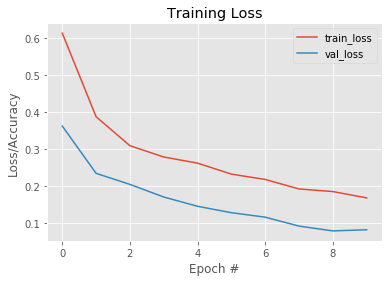

In [44]:
################# Visualisation ###################
# we add an extra 28 pixels to allow for images whose bottom-left is
# at the top or right border
canvas_size = 4000
canvas = np.zeros((canvas_size+imsize, canvas_size+imsize), dtype=float)

def loc2pix(x, size):

    """All values in x are in [-1, 1], we want it in [0, size]."""
    # add 1 to make it non-negative, squeeze to remove trivial
    # dimension and transform.
    x = (((1.0 + x.squeeze()) / 2) * size).astype(int)
    assert np.all(x >= 0) and np.all(x < size)
    return x

for ib, batch in enumerate(test_generator):
    APN, label = batch
    for i in range(batch_size):
        # get the embedding for a, p, n: each should be in [-1, 1]^2
        
        # XXX YOUR CODE HERE. Set a to be the embedding of APN[0][i:i+1],
        # and similarly p for APN[1][i:i+1] and n for APN[2][i:i+1].
        # Think about what you need to call.
        a = base_model.predict(APN[0][i:i+1])
        p = base_model.predict(APN[1][i:i+1])
        n = base_model.predict(APN[2][i:i+1])

        # transform a, p, n to pixel-space [0, 4028]^2
        a = loc2pix(a, canvas_size)
        p = loc2pix(p, canvas_size)
        n = loc2pix(n, canvas_size)
        
        # paint the image of each digit onto the canvas
        canvas[a[0]:a[0]+imsize, a[1]:a[1]+imsize] = APN[0][i].squeeze()
        canvas[p[0]:p[0]+imsize, p[1]:p[1]+imsize] = APN[1][i].squeeze()
        canvas[n[0]:n[0]+imsize, n[1]:n[1]+imsize] = APN[2][i].squeeze()
        
    break # one batch of 100 samples is enough for visualisation

fig, ax = plt.subplots(figsize=(40, 40)) # we have to make it large to avoid subsampling
ax.matshow(canvas)
plt.savefig("keras_mnist_triplet_layout.png")
plt.close()


N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
#plt.plot(N, H.history["acc"], label="train_acc")
#plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("keras_mnist.png")

In [42]:

################# Recognition ###################

def print_num(num):
    for row in num:
        print(' '.join([str(' ' if i[0]==0 else 1) for i in row])) 

db_embedding=dict()

avg_err = 0  
def recognize_digit(image):
    digits = [0,1,2,3,4,5,6,7,8,9]
    image = image.reshape(1,28,28,1)
    image_embedding = base_model.predict(image)
  
    #  min_dist = 100
    predictions = []
    # For each digit
    for digit in digits:
        dist = []
        # Choose an image embedding amoung 3 images with least distance
        for i in range(3):
            img = get_image(digit).reshape(1,28,28,1)
            digit_embedding =  base_model.predict(img)        
            dist.append(np.linalg.norm(image_embedding - digit_embedding))
        # Pick the one with least distance for the digit
        predictions.append(min(dist))   
    
    # Pick the digit with least distance overall
    distance = min(predictions)
    pred = predictions.index(min(predictions))

    if distance > 1.5:
        print('Not a digit')
        return None
    else:
        print('Predicted as : '+str(pred))
        return pred

c = 0     
total = 10000
for i in range(total):
    anchor = X_test[i]
    actual = y_test[i]
    result =recognize_digit(anchor)
    if(actual==result):
        c+=1
    print('------- TEST - COMPLETED : ',(i/total)*100,\
          '% ACCURACY : ',(c/(i+1))*100,'% -------')


Predicted as : 7
------- TEST - COMPLETED :  0.0 % ACCURACY :  100.0 % -------
Predicted as : 2
------- TEST - COMPLETED :  0.01 % ACCURACY :  100.0 % -------
Predicted as : 1
------- TEST - COMPLETED :  0.02 % ACCURACY :  100.0 % -------
Predicted as : 0
------- TEST - COMPLETED :  0.03 % ACCURACY :  100.0 % -------
Predicted as : 4
------- TEST - COMPLETED :  0.04 % ACCURACY :  100.0 % -------
Predicted as : 1
------- TEST - COMPLETED :  0.05 % ACCURACY :  100.0 % -------
Predicted as : 4
------- TEST - COMPLETED :  0.06 % ACCURACY :  100.0 % -------
Predicted as : 4
------- TEST - COMPLETED :  0.06999999999999999 % ACCURACY :  87.5 % -------
Predicted as : 5
------- TEST - COMPLETED :  0.08 % ACCURACY :  88.88888888888889 % -------
Predicted as : 9
------- TEST - COMPLETED :  0.09 % ACCURACY :  90.0 % -------
Predicted as : 0
------- TEST - COMPLETED :  0.1 % ACCURACY :  90.9090909090909 % -------
Predicted as : 6
------- TEST - COMPLETED :  0.11 % ACCURACY :  91.66666666666666 % --

Predicted as : 1
------- TEST - COMPLETED :  0.89 % ACCURACY :  91.11111111111111 % -------
Predicted as : 3
------- TEST - COMPLETED :  0.8999999999999999 % ACCURACY :  91.20879120879121 % -------
Predicted as : 6
------- TEST - COMPLETED :  0.91 % ACCURACY :  91.30434782608695 % -------
Predicted as : 4
------- TEST - COMPLETED :  0.9199999999999999 % ACCURACY :  90.32258064516128 % -------
Predicted as : 3
------- TEST - COMPLETED :  0.9299999999999999 % ACCURACY :  90.42553191489363 % -------
Predicted as : 1
------- TEST - COMPLETED :  0.9400000000000001 % ACCURACY :  90.52631578947368 % -------
Predicted as : 4
------- TEST - COMPLETED :  0.95 % ACCURACY :  90.625 % -------
Predicted as : 8
------- TEST - COMPLETED :  0.96 % ACCURACY :  89.69072164948454 % -------
Predicted as : 7
------- TEST - COMPLETED :  0.97 % ACCURACY :  89.79591836734694 % -------
Predicted as : 6
------- TEST - COMPLETED :  0.98 % ACCURACY :  89.8989898989899 % -------
Predicted as : 9
------- TEST - COMP

Predicted as : 8
------- TEST - COMPLETED :  1.79 % ACCURACY :  91.66666666666666 % -------
Predicted as : 1
------- TEST - COMPLETED :  1.7999999999999998 % ACCURACY :  91.71270718232044 % -------
Predicted as : 8
------- TEST - COMPLETED :  1.81 % ACCURACY :  91.75824175824175 % -------
Predicted as : 5
------- TEST - COMPLETED :  1.82 % ACCURACY :  91.80327868852459 % -------
Predicted as : 0
------- TEST - COMPLETED :  1.83 % ACCURACY :  91.84782608695652 % -------
Predicted as : 1
------- TEST - COMPLETED :  1.8399999999999999 % ACCURACY :  91.35135135135135 % -------
Predicted as : 4
------- TEST - COMPLETED :  1.8499999999999999 % ACCURACY :  90.86021505376344 % -------
Predicted as : 2
------- TEST - COMPLETED :  1.8599999999999999 % ACCURACY :  90.9090909090909 % -------
Predicted as : 5
------- TEST - COMPLETED :  1.87 % ACCURACY :  90.95744680851064 % -------
Predicted as : 0
------- TEST - COMPLETED :  1.8800000000000001 % ACCURACY :  91.005291005291 % -------
Predicted as 

Predicted as : 3
------- TEST - COMPLETED :  2.7 % ACCURACY :  89.66789667896678 % -------
Predicted as : 0
------- TEST - COMPLETED :  2.71 % ACCURACY :  89.70588235294117 % -------
Predicted as : 1
------- TEST - COMPLETED :  2.7199999999999998 % ACCURACY :  89.74358974358975 % -------
Predicted as : 9
------- TEST - COMPLETED :  2.73 % ACCURACY :  89.78102189781022 % -------
Predicted as : 9
------- TEST - COMPLETED :  2.74 % ACCURACY :  89.81818181818181 % -------
Predicted as : 4
------- TEST - COMPLETED :  2.75 % ACCURACY :  89.85507246376811 % -------
Predicted as : 1
------- TEST - COMPLETED :  2.76 % ACCURACY :  89.89169675090253 % -------
Predicted as : 8
------- TEST - COMPLETED :  2.77 % ACCURACY :  89.92805755395683 % -------
Predicted as : 2
------- TEST - COMPLETED :  2.78 % ACCURACY :  89.96415770609319 % -------
Predicted as : 1
------- TEST - COMPLETED :  2.79 % ACCURACY :  90.0 % -------
Predicted as : 2
------- TEST - COMPLETED :  2.8000000000000003 % ACCURACY :  90

Predicted as : 7
------- TEST - COMPLETED :  3.58 % ACCURACY :  88.57938718662952 % -------
Predicted as : 9
------- TEST - COMPLETED :  3.5900000000000003 % ACCURACY :  88.61111111111111 % -------
Predicted as : 4
------- TEST - COMPLETED :  3.5999999999999996 % ACCURACY :  88.64265927977839 % -------
Predicted as : 6
------- TEST - COMPLETED :  3.61 % ACCURACY :  88.67403314917127 % -------
Predicted as : 7
------- TEST - COMPLETED :  3.62 % ACCURACY :  88.42975206611571 % -------
Predicted as : 2
------- TEST - COMPLETED :  3.63 % ACCURACY :  88.46153846153845 % -------
Predicted as : 5
------- TEST - COMPLETED :  3.64 % ACCURACY :  88.4931506849315 % -------
Predicted as : 0
------- TEST - COMPLETED :  3.65 % ACCURACY :  88.52459016393442 % -------
Predicted as : 6
------- TEST - COMPLETED :  3.66 % ACCURACY :  88.5558583106267 % -------
Predicted as : 5
------- TEST - COMPLETED :  3.6700000000000004 % ACCURACY :  88.58695652173914 % -------
Predicted as : 6
------- TEST - COMPLETE

Predicted as : 6
------- TEST - COMPLETED :  4.46 % ACCURACY :  88.36689038031321 % -------
Predicted as : 4
------- TEST - COMPLETED :  4.47 % ACCURACY :  88.39285714285714 % -------
Predicted as : 8
------- TEST - COMPLETED :  4.4799999999999995 % ACCURACY :  88.19599109131403 % -------
Predicted as : 3
------- TEST - COMPLETED :  4.49 % ACCURACY :  88.22222222222223 % -------
Predicted as : 5
------- TEST - COMPLETED :  4.5 % ACCURACY :  88.02660753880266 % -------
Predicted as : 3
------- TEST - COMPLETED :  4.51 % ACCURACY :  88.05309734513274 % -------
Predicted as : 2
------- TEST - COMPLETED :  4.52 % ACCURACY :  88.0794701986755 % -------
Predicted as : 3
------- TEST - COMPLETED :  4.53 % ACCURACY :  88.10572687224669 % -------
Predicted as : 9
------- TEST - COMPLETED :  4.54 % ACCURACY :  88.13186813186813 % -------
Predicted as : 1
------- TEST - COMPLETED :  4.55 % ACCURACY :  88.1578947368421 % -------
Predicted as : 2
------- TEST - COMPLETED :  4.5600000000000005 % ACC

Predicted as : 4
------- TEST - COMPLETED :  5.33 % ACCURACY :  88.01498127340824 % -------
Predicted as : 6
------- TEST - COMPLETED :  5.34 % ACCURACY :  88.03738317757009 % -------
Predicted as : 4
------- TEST - COMPLETED :  5.35 % ACCURACY :  88.05970149253731 % -------
Predicted as : 7
------- TEST - COMPLETED :  5.36 % ACCURACY :  87.89571694599627 % -------
Predicted as : 1
------- TEST - COMPLETED :  5.37 % ACCURACY :  87.9182156133829 % -------
Predicted as : 8
------- TEST - COMPLETED :  5.38 % ACCURACY :  87.94063079777365 % -------
Predicted as : 2
------- TEST - COMPLETED :  5.390000000000001 % ACCURACY :  87.96296296296296 % -------
Predicted as : 5
------- TEST - COMPLETED :  5.4 % ACCURACY :  87.98521256931609 % -------
Predicted as : 4
------- TEST - COMPLETED :  5.41 % ACCURACY :  88.00738007380073 % -------
Predicted as : 8
------- TEST - COMPLETED :  5.42 % ACCURACY :  88.02946593001842 % -------
Predicted as : 9
------- TEST - COMPLETED :  5.43 % ACCURACY :  87.86

Predicted as : 4
------- TEST - COMPLETED :  6.22 % ACCURACY :  87.47993579454254 % -------
Predicted as : 6
------- TEST - COMPLETED :  6.23 % ACCURACY :  87.5 % -------
Predicted as : 2
------- TEST - COMPLETED :  6.239999999999999 % ACCURACY :  87.52 % -------
Predicted as : 6
------- TEST - COMPLETED :  6.25 % ACCURACY :  87.53993610223642 % -------
Predicted as : 7
------- TEST - COMPLETED :  6.260000000000001 % ACCURACY :  87.5598086124402 % -------
Predicted as : 9
------- TEST - COMPLETED :  6.2700000000000005 % ACCURACY :  87.57961783439491 % -------
Predicted as : 3
------- TEST - COMPLETED :  6.279999999999999 % ACCURACY :  87.5993640699523 % -------
Predicted as : 8
------- TEST - COMPLETED :  6.29 % ACCURACY :  87.46031746031746 % -------
Predicted as : 9
------- TEST - COMPLETED :  6.3 % ACCURACY :  87.48019017432647 % -------
Predicted as : 8
------- TEST - COMPLETED :  6.3100000000000005 % ACCURACY :  87.5 % -------
Predicted as : 2
------- TEST - COMPLETED :  6.32 % AC

Predicted as : 4
------- TEST - COMPLETED :  7.12 % ACCURACY :  87.9382889200561 % -------
Predicted as : 0
------- TEST - COMPLETED :  7.13 % ACCURACY :  87.95518207282913 % -------
Predicted as : 8
------- TEST - COMPLETED :  7.140000000000001 % ACCURACY :  87.97202797202797 % -------
Predicted as : 2
------- TEST - COMPLETED :  7.1499999999999995 % ACCURACY :  87.98882681564247 % -------
Predicted as : 1
------- TEST - COMPLETED :  7.16 % ACCURACY :  88.00557880055788 % -------
Predicted as : 0
------- TEST - COMPLETED :  7.17 % ACCURACY :  88.02228412256268 % -------
Predicted as : 8
------- TEST - COMPLETED :  7.180000000000001 % ACCURACY :  88.03894297635605 % -------
Predicted as : 4
------- TEST - COMPLETED :  7.19 % ACCURACY :  88.05555555555556 % -------
Predicted as : 8
------- TEST - COMPLETED :  7.199999999999999 % ACCURACY :  87.93342579750347 % -------
Predicted as : 0
------- TEST - COMPLETED :  7.21 % ACCURACY :  87.95013850415513 % -------
Predicted as : 4
------- TES

Predicted as : 4
------- TEST - COMPLETED :  8.03 % ACCURACY :  87.56218905472637 % -------
Predicted as : 0
------- TEST - COMPLETED :  8.04 % ACCURACY :  87.5776397515528 % -------
Predicted as : 8
------- TEST - COMPLETED :  8.05 % ACCURACY :  87.59305210918114 % -------
Predicted as : 8
------- TEST - COMPLETED :  8.06 % ACCURACY :  87.6084262701363 % -------
Predicted as : 3
------- TEST - COMPLETED :  8.07 % ACCURACY :  87.62376237623762 % -------
Predicted as : 3
------- TEST - COMPLETED :  8.08 % ACCURACY :  87.63906056860321 % -------
Predicted as : 1
------- TEST - COMPLETED :  8.09 % ACCURACY :  87.65432098765432 % -------
Predicted as : 7
------- TEST - COMPLETED :  8.1 % ACCURACY :  87.66954377311961 % -------
Predicted as : 3
------- TEST - COMPLETED :  8.110000000000001 % ACCURACY :  87.68472906403942 % -------
Predicted as : 5
------- TEST - COMPLETED :  8.12 % ACCURACY :  87.69987699877 % -------
Predicted as : 9
------- TEST - COMPLETED :  8.129999999999999 % ACCURACY

Predicted as : 2
------- TEST - COMPLETED :  8.91 % ACCURACY :  88.00448430493275 % -------
Predicted as : 2
------- TEST - COMPLETED :  8.92 % ACCURACY :  88.01791713325868 % -------
Predicted as : 9
------- TEST - COMPLETED :  8.93 % ACCURACY :  88.03131991051454 % -------
Predicted as : 2
------- TEST - COMPLETED :  8.94 % ACCURACY :  87.93296089385476 % -------
Predicted as : 0
------- TEST - COMPLETED :  8.95 % ACCURACY :  87.94642857142857 % -------
Predicted as : 0
------- TEST - COMPLETED :  8.959999999999999 % ACCURACY :  87.95986622073578 % -------
Predicted as : 6
------- TEST - COMPLETED :  8.97 % ACCURACY :  87.8619153674833 % -------
Predicted as : 2
------- TEST - COMPLETED :  8.98 % ACCURACY :  87.76418242491657 % -------
Predicted as : 8
------- TEST - COMPLETED :  8.99 % ACCURACY :  87.77777777777777 % -------
Predicted as : 1
------- TEST - COMPLETED :  9.0 % ACCURACY :  87.79134295227526 % -------
Predicted as : 9
------- TEST - COMPLETED :  9.01 % ACCURACY :  87.69

Predicted as : 1
------- TEST - COMPLETED :  9.84 % ACCURACY :  87.51269035532995 % -------
Predicted as : 2
------- TEST - COMPLETED :  9.85 % ACCURACY :  87.52535496957404 % -------
Predicted as : 6
------- TEST - COMPLETED :  9.86 % ACCURACY :  87.53799392097264 % -------
Predicted as : 7
------- TEST - COMPLETED :  9.87 % ACCURACY :  87.5506072874494 % -------
Predicted as : 1
------- TEST - COMPLETED :  9.879999999999999 % ACCURACY :  87.56319514661274 % -------
Predicted as : 6
------- TEST - COMPLETED :  9.89 % ACCURACY :  87.57575757575758 % -------
Predicted as : 2
------- TEST - COMPLETED :  9.9 % ACCURACY :  87.5882946518668 % -------
Predicted as : 3
------- TEST - COMPLETED :  9.91 % ACCURACY :  87.6008064516129 % -------
Predicted as : 9
------- TEST - COMPLETED :  9.92 % ACCURACY :  87.61329305135952 % -------
Predicted as : 0
------- TEST - COMPLETED :  9.93 % ACCURACY :  87.62575452716298 % -------
Predicted as : 5
------- TEST - COMPLETED :  9.94 % ACCURACY :  87.5376

Predicted as : 2
------- TEST - COMPLETED :  10.76 % ACCURACY :  87.00092850510678 % -------
Predicted as : 9
------- TEST - COMPLETED :  10.77 % ACCURACY :  86.92022263450835 % -------
Predicted as : 4
------- TEST - COMPLETED :  10.780000000000001 % ACCURACY :  86.93234476367007 % -------
Predicted as : 6
------- TEST - COMPLETED :  10.79 % ACCURACY :  86.94444444444444 % -------
Predicted as : 4
------- TEST - COMPLETED :  10.8 % ACCURACY :  86.95652173913044 % -------
Predicted as : 9
------- TEST - COMPLETED :  10.81 % ACCURACY :  86.96857670979668 % -------
Predicted as : 5
------- TEST - COMPLETED :  10.82 % ACCURACY :  86.98060941828255 % -------
Predicted as : 1
------- TEST - COMPLETED :  10.83 % ACCURACY :  86.99261992619927 % -------
Predicted as : 0
------- TEST - COMPLETED :  10.84 % ACCURACY :  87.00460829493088 % -------
Predicted as : 6
------- TEST - COMPLETED :  10.85 % ACCURACY :  87.01657458563537 % -------
Predicted as : 9
------- TEST - COMPLETED :  10.86 % ACCUR

Predicted as : 9
------- TEST - COMPLETED :  11.64 % ACCURACY :  86.78111587982833 % -------
Predicted as : 9
------- TEST - COMPLETED :  11.65 % ACCURACY :  86.79245283018868 % -------
Predicted as : 5
------- TEST - COMPLETED :  11.66 % ACCURACY :  86.71808054841473 % -------
Predicted as : 4
------- TEST - COMPLETED :  11.67 % ACCURACY :  86.72945205479452 % -------
Predicted as : 5
------- TEST - COMPLETED :  11.68 % ACCURACY :  86.74080410607357 % -------
Predicted as : 5
------- TEST - COMPLETED :  11.690000000000001 % ACCURACY :  86.75213675213675 % -------
Predicted as : 5
------- TEST - COMPLETED :  11.700000000000001 % ACCURACY :  86.67805294619983 % -------
Predicted as : 7
------- TEST - COMPLETED :  11.709999999999999 % ACCURACY :  86.68941979522185 % -------
Predicted as : 3
------- TEST - COMPLETED :  11.72 % ACCURACY :  86.70076726342711 % -------
Predicted as : 9
------- TEST - COMPLETED :  11.73 % ACCURACY :  86.62691652470187 % -------
Predicted as : 2
------- TEST -

Predicted as : 3
------- TEST - COMPLETED :  12.520000000000001 % ACCURACY :  86.27294493216282 % -------
Predicted as : 4
------- TEST - COMPLETED :  12.53 % ACCURACY :  86.28389154704944 % -------
Predicted as : 1
------- TEST - COMPLETED :  12.540000000000001 % ACCURACY :  86.29482071713147 % -------
Predicted as : 9
------- TEST - COMPLETED :  12.55 % ACCURACY :  86.30573248407643 % -------
Predicted as : 7
------- TEST - COMPLETED :  12.559999999999999 % ACCURACY :  86.2370723945903 % -------
Predicted as : 1
------- TEST - COMPLETED :  12.57 % ACCURACY :  86.24801271860095 % -------
Predicted as : 5
------- TEST - COMPLETED :  12.58 % ACCURACY :  86.25893566322478 % -------
Predicted as : 8
------- TEST - COMPLETED :  12.590000000000002 % ACCURACY :  86.26984126984128 % -------
Predicted as : 8
------- TEST - COMPLETED :  12.6 % ACCURACY :  86.20142743854085 % -------
Predicted as : 0
------- TEST - COMPLETED :  12.61 % ACCURACY :  86.2123613312203 % -------
Predicted as : 2
----

Predicted as : 5
------- TEST - COMPLETED :  13.4 % ACCURACY :  86.20432513049963 % -------
Predicted as : 2
------- TEST - COMPLETED :  13.41 % ACCURACY :  86.21460506706408 % -------
Predicted as : 4
------- TEST - COMPLETED :  13.420000000000002 % ACCURACY :  86.22486969471332 % -------
Predicted as : 9
------- TEST - COMPLETED :  13.43 % ACCURACY :  86.23511904761905 % -------
Predicted as : 6
------- TEST - COMPLETED :  13.44 % ACCURACY :  86.2453531598513 % -------
Predicted as : 2
------- TEST - COMPLETED :  13.450000000000001 % ACCURACY :  86.2555720653789 % -------
Predicted as : 7
------- TEST - COMPLETED :  13.459999999999999 % ACCURACY :  86.26577579806978 % -------
Predicted as : 7
------- TEST - COMPLETED :  13.469999999999999 % ACCURACY :  86.27596439169139 % -------
Predicted as : 2
------- TEST - COMPLETED :  13.48 % ACCURACY :  86.28613787991104 % -------
Predicted as : 2
------- TEST - COMPLETED :  13.489999999999998 % ACCURACY :  86.29629629629629 % -------
Predicte

Predicted as : 9
------- TEST - COMPLETED :  14.280000000000001 % ACCURACY :  86.49405178446466 % -------
Predicted as : 4
------- TEST - COMPLETED :  14.29 % ACCURACY :  86.43356643356643 % -------
Predicted as : 1
------- TEST - COMPLETED :  14.299999999999999 % ACCURACY :  86.44304682040531 % -------
Predicted as : 2
------- TEST - COMPLETED :  14.31 % ACCURACY :  86.45251396648045 % -------
Predicted as : 2
------- TEST - COMPLETED :  14.32 % ACCURACY :  86.46196789951152 % -------
Predicted as : 8
------- TEST - COMPLETED :  14.330000000000002 % ACCURACY :  86.47140864714086 % -------
Predicted as : 1
------- TEST - COMPLETED :  14.34 % ACCURACY :  86.4808362369338 % -------
Predicted as : 9
------- TEST - COMPLETED :  14.35 % ACCURACY :  86.49025069637884 % -------
Predicted as : 6
------- TEST - COMPLETED :  14.360000000000001 % ACCURACY :  86.49965205288797 % -------
Predicted as : 4
------- TEST - COMPLETED :  14.37 % ACCURACY :  86.50904033379693 % -------
Predicted as : 0
--

Predicted as : 4
------- TEST - COMPLETED :  15.160000000000002 % ACCURACY :  86.75016479894528 % -------
Predicted as : 0
------- TEST - COMPLETED :  15.17 % ACCURACY :  86.7588932806324 % -------
Predicted as : 2
------- TEST - COMPLETED :  15.18 % ACCURACY :  86.76761026991441 % -------
Predicted as : 3
------- TEST - COMPLETED :  15.190000000000001 % ACCURACY :  86.77631578947368 % -------
Predicted as : 2
------- TEST - COMPLETED :  15.2 % ACCURACY :  86.71926364234056 % -------
Predicted as : 5
------- TEST - COMPLETED :  15.21 % ACCURACY :  86.72798948751642 % -------
Predicted as : 9
------- TEST - COMPLETED :  15.22 % ACCURACY :  86.67104399212081 % -------
Predicted as : 2
------- TEST - COMPLETED :  15.229999999999999 % ACCURACY :  86.61417322834646 % -------
Predicted as : 8
------- TEST - COMPLETED :  15.24 % ACCURACY :  86.62295081967213 % -------
Predicted as : 0
------- TEST - COMPLETED :  15.25 % ACCURACY :  86.56618610747051 % -------
Predicted as : 0
------- TEST - C

Predicted as : 1
------- TEST - COMPLETED :  16.03 % ACCURACY :  86.53366583541147 % -------
Predicted as : 2
------- TEST - COMPLETED :  16.04 % ACCURACY :  86.54205607476636 % -------
Predicted as : 3
------- TEST - COMPLETED :  16.05 % ACCURACY :  86.55043586550435 % -------
Predicted as : 9
------- TEST - COMPLETED :  16.06 % ACCURACY :  86.4965774735532 % -------
Predicted as : 5
------- TEST - COMPLETED :  16.07 % ACCURACY :  86.44278606965175 % -------
Predicted as : 3
------- TEST - COMPLETED :  16.08 % ACCURACY :  86.45121193287756 % -------
Predicted as : 2
------- TEST - COMPLETED :  16.09 % ACCURACY :  86.45962732919254 % -------
Predicted as : 0
------- TEST - COMPLETED :  16.1 % ACCURACY :  86.46803227808815 % -------
Predicted as : 3
------- TEST - COMPLETED :  16.11 % ACCURACY :  86.47642679900744 % -------
Predicted as : 3
------- TEST - COMPLETED :  16.12 % ACCURACY :  86.48481091134532 % -------
Predicted as : 8
------- TEST - COMPLETED :  16.13 % ACCURACY :  86.4931

Predicted as : 1
------- TEST - COMPLETED :  16.91 % ACCURACY :  86.4066193853428 % -------
Predicted as : 0
------- TEST - COMPLETED :  16.919999999999998 % ACCURACY :  86.41464855286473 % -------
Predicted as : 5
------- TEST - COMPLETED :  16.93 % ACCURACY :  86.42266824085006 % -------
Predicted as : 2
------- TEST - COMPLETED :  16.939999999999998 % ACCURACY :  86.3716814159292 % -------
Predicted as : 9
------- TEST - COMPLETED :  16.950000000000003 % ACCURACY :  86.37971698113208 % -------
Predicted as : 8
------- TEST - COMPLETED :  16.96 % ACCURACY :  86.32881555686505 % -------
Predicted as : 9
------- TEST - COMPLETED :  16.97 % ACCURACY :  86.33686690223793 % -------
Predicted as : 6
------- TEST - COMPLETED :  16.98 % ACCURACY :  86.34490876986463 % -------
Predicted as : 7
------- TEST - COMPLETED :  16.99 % ACCURACY :  86.3529411764706 % -------
Predicted as : 0
------- TEST - COMPLETED :  17.0 % ACCURACY :  86.36096413874192 % -------
Predicted as : 4
------- TEST - COM

Predicted as : 0
------- TEST - COMPLETED :  17.77 % ACCURACY :  86.16422947131609 % -------
Predicted as : 4
------- TEST - COMPLETED :  17.78 % ACCURACY :  86.17200674536257 % -------
Predicted as : 5
------- TEST - COMPLETED :  17.79 % ACCURACY :  86.12359550561798 % -------
Predicted as : 1
------- TEST - COMPLETED :  17.8 % ACCURACY :  86.13138686131386 % -------
Predicted as : 4
------- TEST - COMPLETED :  17.810000000000002 % ACCURACY :  86.08305274971941 % -------
Predicted as : 8
------- TEST - COMPLETED :  17.82 % ACCURACY :  86.09085810431857 % -------
Predicted as : 7
------- TEST - COMPLETED :  17.83 % ACCURACY :  86.09865470852019 % -------
Predicted as : 7
------- TEST - COMPLETED :  17.84 % ACCURACY :  86.10644257703082 % -------
Predicted as : 1
------- TEST - COMPLETED :  17.849999999999998 % ACCURACY :  86.11422172452407 % -------
Predicted as : 4
------- TEST - COMPLETED :  17.86 % ACCURACY :  86.12199216564073 % -------
Predicted as : 9
------- TEST - COMPLETED :  

Predicted as : 2
------- TEST - COMPLETED :  18.709999999999997 % ACCURACY :  86.43162393162393 % -------
Predicted as : 4
------- TEST - COMPLETED :  18.72 % ACCURACY :  86.43886812600107 % -------
Predicted as : 9
------- TEST - COMPLETED :  18.73 % ACCURACY :  86.44610458911419 % -------
Predicted as : 5
------- TEST - COMPLETED :  18.740000000000002 % ACCURACY :  86.45333333333333 % -------
Predicted as : 7
------- TEST - COMPLETED :  18.75 % ACCURACY :  86.46055437100213 % -------
Predicted as : 1
------- TEST - COMPLETED :  18.759999999999998 % ACCURACY :  86.46776771443794 % -------
Predicted as : 8
------- TEST - COMPLETED :  18.77 % ACCURACY :  86.47497337593184 % -------
Predicted as : 8
------- TEST - COMPLETED :  18.78 % ACCURACY :  86.4821713677488 % -------
Predicted as : 5
------- TEST - COMPLETED :  18.790000000000003 % ACCURACY :  86.48936170212767 % -------
Predicted as : 6
------- TEST - COMPLETED :  18.8 % ACCURACY :  86.49654439128123 % -------
Predicted as : 4
---

Predicted as : 4
------- TEST - COMPLETED :  19.580000000000002 % ACCURACY :  86.67687595712098 % -------
Predicted as : 0
------- TEST - COMPLETED :  19.59 % ACCURACY :  86.68367346938776 % -------
Predicted as : 8
------- TEST - COMPLETED :  19.6 % ACCURACY :  86.69046404895462 % -------
Predicted as : 8
------- TEST - COMPLETED :  19.61 % ACCURACY :  86.69724770642202 % -------
Predicted as : 3
------- TEST - COMPLETED :  19.62 % ACCURACY :  86.70402445236883 % -------
Predicted as : 4
------- TEST - COMPLETED :  19.63 % ACCURACY :  86.71079429735235 % -------
Predicted as : 4
------- TEST - COMPLETED :  19.64 % ACCURACY :  86.66666666666667 % -------
Predicted as : 2
------- TEST - COMPLETED :  19.650000000000002 % ACCURACY :  86.6734486266531 % -------
Predicted as : 7
------- TEST - COMPLETED :  19.66 % ACCURACY :  86.68022369089985 % -------
Predicted as : 5
------- TEST - COMPLETED :  19.67 % ACCURACY :  86.6869918699187 % -------
Predicted as : 1
------- TEST - COMPLETED :  19

Predicted as : 8
------- TEST - COMPLETED :  20.44 % ACCURACY :  86.40586797066014 % -------
Predicted as : 3
------- TEST - COMPLETED :  20.45 % ACCURACY :  86.41251221896383 % -------
Predicted as : 4
------- TEST - COMPLETED :  20.46 % ACCURACY :  86.419149975574 % -------
Predicted as : 0
------- TEST - COMPLETED :  20.47 % ACCURACY :  86.376953125 % -------
Predicted as : 7
------- TEST - COMPLETED :  20.48 % ACCURACY :  86.3836017569546 % -------
Predicted as : 9
------- TEST - COMPLETED :  20.49 % ACCURACY :  86.39024390243902 % -------
Predicted as : 8
------- TEST - COMPLETED :  20.5 % ACCURACY :  86.39687957094101 % -------
Predicted as : 1
------- TEST - COMPLETED :  20.51 % ACCURACY :  86.40350877192982 % -------
Predicted as : 8
------- TEST - COMPLETED :  20.52 % ACCURACY :  86.4101315148563 % -------
Predicted as : 4
------- TEST - COMPLETED :  20.53 % ACCURACY :  86.41674780915287 % -------
Predicted as : 9
------- TEST - COMPLETED :  20.54 % ACCURACY :  86.423357664233

Predicted as : 7
------- TEST - COMPLETED :  21.32 % ACCURACY :  86.02906704172527 % -------
Predicted as : 2
------- TEST - COMPLETED :  21.33 % ACCURACY :  86.03561387066541 % -------
Predicted as : 5
------- TEST - COMPLETED :  21.34 % ACCURACY :  86.04215456674473 % -------
Predicted as : 1
------- TEST - COMPLETED :  21.349999999999998 % ACCURACY :  86.00187265917603 % -------
Predicted as : 8
------- TEST - COMPLETED :  21.36 % ACCURACY :  85.96162845109967 % -------
Predicted as : 1
------- TEST - COMPLETED :  21.37 % ACCURACY :  85.96819457436857 % -------
Predicted as : 2
------- TEST - COMPLETED :  21.38 % ACCURACY :  85.97475455820476 % -------
Predicted as : 3
------- TEST - COMPLETED :  21.39 % ACCURACY :  85.98130841121495 % -------
Predicted as : 6
------- TEST - COMPLETED :  21.4 % ACCURACY :  85.98785614198972 % -------
Predicted as : 7
------- TEST - COMPLETED :  21.41 % ACCURACY :  85.99439775910365 % -------
Predicted as : 2
------- TEST - COMPLETED :  21.42 % ACCUR

Predicted as : 4
------- TEST - COMPLETED :  22.23 % ACCURACY :  85.88129496402878 % -------
Predicted as : 8
------- TEST - COMPLETED :  22.24 % ACCURACY :  85.84269662921349 % -------
Predicted as : 8
------- TEST - COMPLETED :  22.25 % ACCURACY :  85.84905660377359 % -------
Predicted as : 0
------- TEST - COMPLETED :  22.259999999999998 % ACCURACY :  85.85541086663673 % -------
Predicted as : 7
------- TEST - COMPLETED :  22.27 % ACCURACY :  85.81687612208259 % -------
Predicted as : 1
------- TEST - COMPLETED :  22.28 % ACCURACY :  85.82323912068192 % -------
Predicted as : 3
------- TEST - COMPLETED :  22.29 % ACCURACY :  85.82959641255606 % -------
Predicted as : 3
------- TEST - COMPLETED :  22.3 % ACCURACY :  85.83594800537875 % -------
Predicted as : 6
------- TEST - COMPLETED :  22.31 % ACCURACY :  85.84229390681004 % -------
Predicted as : 4
------- TEST - COMPLETED :  22.32 % ACCURACY :  85.80385132109271 % -------
Predicted as : 4
------- TEST - COMPLETED :  22.33 % ACCUR

Predicted as : 7
------- TEST - COMPLETED :  23.169999999999998 % ACCURACY :  85.89301121656601 % -------
Predicted as : 6
------- TEST - COMPLETED :  23.18 % ACCURACY :  85.85597240189738 % -------
Predicted as : 6
------- TEST - COMPLETED :  23.189999999999998 % ACCURACY :  85.81896551724138 % -------
Predicted as : 4
------- TEST - COMPLETED :  23.200000000000003 % ACCURACY :  85.78199052132702 % -------
Predicted as : 6
------- TEST - COMPLETED :  23.21 % ACCURACY :  85.78811369509044 % -------
Predicted as : 5
------- TEST - COMPLETED :  23.22 % ACCURACY :  85.79423159707275 % -------
Predicted as : 9
------- TEST - COMPLETED :  23.23 % ACCURACY :  85.80034423407918 % -------
Predicted as : 1
------- TEST - COMPLETED :  23.24 % ACCURACY :  85.80645161290322 % -------
Predicted as : 2
------- TEST - COMPLETED :  23.25 % ACCURACY :  85.76956147893378 % -------
Predicted as : 0
------- TEST - COMPLETED :  23.26 % ACCURACY :  85.77567683712935 % -------
Predicted as : 2
------- TEST -

Predicted as : 8
------- TEST - COMPLETED :  24.060000000000002 % ACCURACY :  85.66680515164104 % -------
Predicted as : 7
------- TEST - COMPLETED :  24.07 % ACCURACY :  85.67275747508306 % -------
Predicted as : 9
------- TEST - COMPLETED :  24.08 % ACCURACY :  85.63719385637194 % -------
Predicted as : 1
------- TEST - COMPLETED :  24.09 % ACCURACY :  85.64315352697095 % -------
Predicted as : 0
------- TEST - COMPLETED :  24.099999999999998 % ACCURACY :  85.64910825383659 % -------
Predicted as : 1
------- TEST - COMPLETED :  24.11 % ACCURACY :  85.65505804311775 % -------
Predicted as : 2
------- TEST - COMPLETED :  24.12 % ACCURACY :  85.66100290095316 % -------
Predicted as : 5
------- TEST - COMPLETED :  24.13 % ACCURACY :  85.66694283347141 % -------
Predicted as : 8
------- TEST - COMPLETED :  24.14 % ACCURACY :  85.63146997929607 % -------
Predicted as : 2
------- TEST - COMPLETED :  24.15 % ACCURACY :  85.63741721854305 % -------
Predicted as : 1
------- TEST - COMPLETED : 

Predicted as : 2
------- TEST - COMPLETED :  24.95 % ACCURACY :  85.8173076923077 % -------
Predicted as : 2
------- TEST - COMPLETED :  24.959999999999997 % ACCURACY :  85.82298758510211 % -------
Predicted as : 9
------- TEST - COMPLETED :  24.97 % ACCURACY :  85.82866293034428 % -------
Predicted as : 4
------- TEST - COMPLETED :  24.98 % ACCURACY :  85.8343337334934 % -------
Predicted as : 4
------- TEST - COMPLETED :  24.990000000000002 % ACCURACY :  85.84 % -------
Predicted as : 2
------- TEST - COMPLETED :  25.0 % ACCURACY :  85.84566173530588 % -------
Predicted as : 3
------- TEST - COMPLETED :  25.009999999999998 % ACCURACY :  85.85131894484412 % -------
Predicted as : 3
------- TEST - COMPLETED :  25.019999999999996 % ACCURACY :  85.85697163403914 % -------
Predicted as : 2
------- TEST - COMPLETED :  25.03 % ACCURACY :  85.8626198083067 % -------
Predicted as : 1
------- TEST - COMPLETED :  25.040000000000003 % ACCURACY :  85.8682634730539 % -------
Predicted as : 7
-----

Predicted as : 9
------- TEST - COMPLETED :  25.85 % ACCURACY :  85.80819798917247 % -------
Predicted as : 5
------- TEST - COMPLETED :  25.86 % ACCURACY :  85.81368380363355 % -------
Predicted as : 3
------- TEST - COMPLETED :  25.869999999999997 % ACCURACY :  85.81916537867079 % -------
Predicted as : 7
------- TEST - COMPLETED :  25.88 % ACCURACY :  85.8246427191966 % -------
Predicted as : 7
------- TEST - COMPLETED :  25.89 % ACCURACY :  85.7915057915058 % -------
Predicted as : 1
------- TEST - COMPLETED :  25.900000000000002 % ACCURACY :  85.796989579313 % -------
Predicted as : 7
------- TEST - COMPLETED :  25.91 % ACCURACY :  85.80246913580247 % -------
Predicted as : 0
------- TEST - COMPLETED :  25.919999999999998 % ACCURACY :  85.80794446586964 % -------
Predicted as : 0
------- TEST - COMPLETED :  25.929999999999996 % ACCURACY :  85.81341557440247 % -------
Predicted as : 5
------- TEST - COMPLETED :  25.94 % ACCURACY :  85.78034682080926 % -------
Predicted as : 7
-----

Predicted as : 5
------- TEST - COMPLETED :  26.700000000000003 % ACCURACY :  85.96031448895545 % -------
Predicted as : 7
------- TEST - COMPLETED :  26.71 % ACCURACY :  85.96556886227546 % -------
Predicted as : 6
------- TEST - COMPLETED :  26.72 % ACCURACY :  85.97081930415264 % -------
Predicted as : 4
------- TEST - COMPLETED :  26.729999999999997 % ACCURACY :  85.93866866118175 % -------
Predicted as : 1
------- TEST - COMPLETED :  26.740000000000002 % ACCURACY :  85.94392523364486 % -------
Predicted as : 4
------- TEST - COMPLETED :  26.75 % ACCURACY :  85.949177877429 % -------
Predicted as : 1
------- TEST - COMPLETED :  26.76 % ACCURACY :  85.95442659693687 % -------
Predicted as : 6
------- TEST - COMPLETED :  26.77 % ACCURACY :  85.9596713965646 % -------
Predicted as : 9
------- TEST - COMPLETED :  26.779999999999998 % ACCURACY :  85.92758491974617 % -------
Predicted as : 2
------- TEST - COMPLETED :  26.790000000000003 % ACCURACY :  85.93283582089552 % -------
Predicte

Predicted as : 1
------- TEST - COMPLETED :  27.57 % ACCURACY :  86.14938361131254 % -------
Predicted as : 8
------- TEST - COMPLETED :  27.58 % ACCURACY :  86.15440376948169 % -------
Predicted as : 6
------- TEST - COMPLETED :  27.589999999999996 % ACCURACY :  86.15942028985508 % -------
Predicted as : 9
------- TEST - COMPLETED :  27.6 % ACCURACY :  86.16443317638537 % -------
Predicted as : 0
------- TEST - COMPLETED :  27.61 % ACCURACY :  86.16944243301955 % -------
Predicted as : 6
------- TEST - COMPLETED :  27.62 % ACCURACY :  86.17444806369889 % -------
Predicted as : 0
------- TEST - COMPLETED :  27.63 % ACCURACY :  86.1794500723589 % -------
Predicted as : 0
------- TEST - COMPLETED :  27.639999999999997 % ACCURACY :  86.18444846292948 % -------
Predicted as : 0
------- TEST - COMPLETED :  27.650000000000002 % ACCURACY :  86.18944323933478 % -------
Predicted as : 6
------- TEST - COMPLETED :  27.66 % ACCURACY :  86.19443440549331 % -------
Predicted as : 3
------- TEST - C

Predicted as : 7
------- TEST - COMPLETED :  28.439999999999998 % ACCURACY :  86.25659050966607 % -------
Predicted as : 9
------- TEST - COMPLETED :  28.449999999999996 % ACCURACY :  86.26141953619114 % -------
Predicted as : 6
------- TEST - COMPLETED :  28.46 % ACCURACY :  86.26624517035476 % -------
Predicted as : 9
------- TEST - COMPLETED :  28.470000000000002 % ACCURACY :  86.23595505617978 % -------
Predicted as : 2
------- TEST - COMPLETED :  28.48 % ACCURACY :  86.24078624078624 % -------
Predicted as : 8
------- TEST - COMPLETED :  28.49 % ACCURACY :  86.24561403508771 % -------
Predicted as : 0
------- TEST - COMPLETED :  28.499999999999996 % ACCURACY :  86.21536303051562 % -------
Predicted as : 7
------- TEST - COMPLETED :  28.51 % ACCURACY :  86.22019635343618 % -------
Predicted as : 8
------- TEST - COMPLETED :  28.52 % ACCURACY :  86.22502628811776 % -------
Predicted as : 3
------- TEST - COMPLETED :  28.53 % ACCURACY :  86.22985283812193 % -------
Predicted as : 9
-

Predicted as : 5
------- TEST - COMPLETED :  29.299999999999997 % ACCURACY :  86.11395428181507 % -------
Predicted as : 3
------- TEST - COMPLETED :  29.310000000000002 % ACCURACY :  86.11869031377898 % -------
Predicted as : 0
------- TEST - COMPLETED :  29.32 % ACCURACY :  86.12342311626321 % -------
Predicted as : 6
------- TEST - COMPLETED :  29.330000000000002 % ACCURACY :  86.12815269256987 % -------
Predicted as : 9
------- TEST - COMPLETED :  29.34 % ACCURACY :  86.13287904599659 % -------
Predicted as : 8
------- TEST - COMPLETED :  29.349999999999998 % ACCURACY :  86.13760217983652 % -------
Predicted as : 4
------- TEST - COMPLETED :  29.360000000000003 % ACCURACY :  86.14232209737828 % -------
Predicted as : 0
------- TEST - COMPLETED :  29.37 % ACCURACY :  86.14703880190606 % -------
Predicted as : 4
------- TEST - COMPLETED :  29.38 % ACCURACY :  86.15175229669956 % -------
Predicted as : 9
------- TEST - COMPLETED :  29.39 % ACCURACY :  86.156462585034 % -------
Predict

Predicted as : 3
------- TEST - COMPLETED :  30.15 % ACCURACY :  86.1737400530504 % -------
Predicted as : 0
------- TEST - COMPLETED :  30.159999999999997 % ACCURACY :  86.17832283725555 % -------
Predicted as : 4
------- TEST - COMPLETED :  30.17 % ACCURACY :  86.18290258449304 % -------
Predicted as : 6
------- TEST - COMPLETED :  30.18 % ACCURACY :  86.18747929778073 % -------
Predicted as : 1
------- TEST - COMPLETED :  30.19 % ACCURACY :  86.19205298013244 % -------
Predicted as : 0
------- TEST - COMPLETED :  30.2 % ACCURACY :  86.1966236345581 % -------
Predicted as : 2
------- TEST - COMPLETED :  30.209999999999997 % ACCURACY :  86.20119126406354 % -------
Predicted as : 5
------- TEST - COMPLETED :  30.220000000000002 % ACCURACY :  86.20575587165068 % -------
Predicted as : 6
------- TEST - COMPLETED :  30.23 % ACCURACY :  86.17724867724867 % -------
Predicted as : 4
------- TEST - COMPLETED :  30.240000000000002 % ACCURACY :  86.18181818181819 % -------
Predicted as : 4
----

Predicted as : 1
------- TEST - COMPLETED :  30.990000000000002 % ACCURACY :  86.25806451612902 % -------
Predicted as : 3
------- TEST - COMPLETED :  31.0 % ACCURACY :  86.23024830699775 % -------
Predicted as : 7
------- TEST - COMPLETED :  31.009999999999998 % ACCURACY :  86.23468729851709 % -------
Predicted as : 3
------- TEST - COMPLETED :  31.019999999999996 % ACCURACY :  86.20689655172413 % -------
Predicted as : 7
------- TEST - COMPLETED :  31.03 % ACCURACY :  86.21134020618557 % -------
Predicted as : 3
------- TEST - COMPLETED :  31.04 % ACCURACY :  86.21578099838969 % -------
Predicted as : 2
------- TEST - COMPLETED :  31.05 % ACCURACY :  86.22021893110109 % -------
Predicted as : 5
------- TEST - COMPLETED :  31.06 % ACCURACY :  86.19246861924687 % -------
Predicted as : 7
------- TEST - COMPLETED :  31.069999999999997 % ACCURACY :  86.1969111969112 % -------
Predicted as : 3
------- TEST - COMPLETED :  31.080000000000002 % ACCURACY :  86.20135091669347 % -------
Predict

Predicted as : 9
------- TEST - COMPLETED :  31.900000000000002 % ACCURACY :  86.08586649952993 % -------
Predicted as : 0
------- TEST - COMPLETED :  31.91 % ACCURACY :  86.09022556390977 % -------
Predicted as : 7
------- TEST - COMPLETED :  31.919999999999998 % ACCURACY :  86.09458189790166 % -------
Predicted as : 2
------- TEST - COMPLETED :  31.929999999999996 % ACCURACY :  86.06762680025048 % -------
Predicted as : 4
------- TEST - COMPLETED :  31.94 % ACCURACY :  86.07198748043818 % -------
Predicted as : 2
------- TEST - COMPLETED :  31.95 % ACCURACY :  86.07634543178973 % -------
Predicted as : 1
------- TEST - COMPLETED :  31.96 % ACCURACY :  86.08070065686582 % -------
Predicted as : 8
------- TEST - COMPLETED :  31.97 % ACCURACY :  86.08505315822389 % -------
Predicted as : 8
------- TEST - COMPLETED :  31.979999999999997 % ACCURACY :  86.08940293841826 % -------
Predicted as : 5
------- TEST - COMPLETED :  31.990000000000002 % ACCURACY :  86.09375 % -------
Predicted as :

Predicted as : 1
------- TEST - COMPLETED :  32.81 % ACCURACY :  86.13650213284583 % -------
Predicted as : 4
------- TEST - COMPLETED :  32.82 % ACCURACY :  86.14072494669509 % -------
Predicted as : 3
------- TEST - COMPLETED :  32.83 % ACCURACY :  86.14494518879415 % -------
Predicted as : 8
------- TEST - COMPLETED :  32.84 % ACCURACY :  86.14916286149162 % -------
Predicted as : 3
------- TEST - COMPLETED :  32.85 % ACCURACY :  86.1533779671333 % -------
Predicted as : 9
------- TEST - COMPLETED :  32.86 % ACCURACY :  86.15759050806207 % -------
Predicted as : 9
------- TEST - COMPLETED :  32.87 % ACCURACY :  86.161800486618 % -------
Predicted as : 4
------- TEST - COMPLETED :  32.879999999999995 % ACCURACY :  86.16600790513834 % -------
Predicted as : 8
------- TEST - COMPLETED :  32.89 % ACCURACY :  86.17021276595744 % -------
Predicted as : 3
------- TEST - COMPLETED :  32.9 % ACCURACY :  86.17441507140686 % -------
Predicted as : 4
------- TEST - COMPLETED :  32.9100000000000

Predicted as : 8
------- TEST - COMPLETED :  33.69 % ACCURACY :  86.23145400593472 % -------
Predicted as : 4
------- TEST - COMPLETED :  33.7 % ACCURACY :  86.23553841590032 % -------
Predicted as : 0
------- TEST - COMPLETED :  33.71 % ACCURACY :  86.23962040332147 % -------
Predicted as : 5
------- TEST - COMPLETED :  33.72 % ACCURACY :  86.24369997035281 % -------
Predicted as : 7
------- TEST - COMPLETED :  33.73 % ACCURACY :  86.24777711914642 % -------
Predicted as : 8
------- TEST - COMPLETED :  33.739999999999995 % ACCURACY :  86.25185185185185 % -------
Predicted as : 2
------- TEST - COMPLETED :  33.75 % ACCURACY :  86.25592417061611 % -------
Predicted as : 9
------- TEST - COMPLETED :  33.76 % ACCURACY :  86.23038199585432 % -------
Predicted as : 4
------- TEST - COMPLETED :  33.77 % ACCURACY :  86.23445825932504 % -------
Predicted as : 7
------- TEST - COMPLETED :  33.78 % ACCURACY :  86.23853211009175 % -------
Predicted as : 1
------- TEST - COMPLETED :  33.79 % ACCUR

Predicted as : 3
------- TEST - COMPLETED :  34.56 % ACCURACY :  86.17298235464276 % -------
Predicted as : 1
------- TEST - COMPLETED :  34.57 % ACCURACY :  86.17698091382302 % -------
Predicted as : 0
------- TEST - COMPLETED :  34.58 % ACCURACY :  86.1809771610292 % -------
Predicted as : 9
------- TEST - COMPLETED :  34.589999999999996 % ACCURACY :  86.18497109826589 % -------
Predicted as : 4
------- TEST - COMPLETED :  34.599999999999994 % ACCURACY :  86.16006934412019 % -------
Predicted as : 7
------- TEST - COMPLETED :  34.61 % ACCURACY :  86.16406701328711 % -------
Predicted as : 5
------- TEST - COMPLETED :  34.62 % ACCURACY :  86.16806237366445 % -------
Predicted as : 4
------- TEST - COMPLETED :  34.63 % ACCURACY :  86.17205542725173 % -------
Predicted as : 1
------- TEST - COMPLETED :  34.64 % ACCURACY :  86.17604617604617 % -------
Predicted as : 4
------- TEST - COMPLETED :  34.65 % ACCURACY :  86.1800346220427 % -------
Predicted as : 8
------- TEST - COMPLETED :  3

Predicted as : 4
------- TEST - COMPLETED :  35.44 % ACCURACY :  86.29055007052186 % -------
Predicted as : 6
------- TEST - COMPLETED :  35.449999999999996 % ACCURACY :  86.29441624365482 % -------
Predicted as : 1
------- TEST - COMPLETED :  35.46 % ACCURACY :  86.29828023681985 % -------
Predicted as : 2
------- TEST - COMPLETED :  35.47 % ACCURACY :  86.3021420518602 % -------
Predicted as : 3
------- TEST - COMPLETED :  35.480000000000004 % ACCURACY :  86.30600169061708 % -------
Predicted as : 8
------- TEST - COMPLETED :  35.49 % ACCURACY :  86.28169014084507 % -------
Predicted as : 6
------- TEST - COMPLETED :  35.5 % ACCURACY :  86.28555336524923 % -------
Predicted as : 4
------- TEST - COMPLETED :  35.510000000000005 % ACCURACY :  86.28941441441441 % -------
Predicted as : 5
------- TEST - COMPLETED :  35.52 % ACCURACY :  86.29327329017732 % -------
Predicted as : 9
------- TEST - COMPLETED :  35.53 % ACCURACY :  86.29712999437254 % -------
Predicted as : 6
------- TEST - C

Predicted as : 7
------- TEST - COMPLETED :  36.370000000000005 % ACCURACY :  86.28367234744366 % -------
Predicted as : 1
------- TEST - COMPLETED :  36.38 % ACCURACY :  86.28744160483649 % -------
Predicted as : 1
------- TEST - COMPLETED :  36.39 % ACCURACY :  86.29120879120879 % -------
Predicted as : 0
------- TEST - COMPLETED :  36.4 % ACCURACY :  86.29497390826695 % -------
Predicted as : 1
------- TEST - COMPLETED :  36.41 % ACCURACY :  86.29873695771553 % -------
Predicted as : 3
------- TEST - COMPLETED :  36.42 % ACCURACY :  86.3024979412572 % -------
Predicted as : 7
------- TEST - COMPLETED :  36.43 % ACCURACY :  86.30625686059275 % -------
Predicted as : 8
------- TEST - COMPLETED :  36.44 % ACCURACY :  86.31001371742113 % -------
Predicted as : 5
------- TEST - COMPLETED :  36.449999999999996 % ACCURACY :  86.31376851343938 % -------
Predicted as : 0
------- TEST - COMPLETED :  36.46 % ACCURACY :  86.31752125034275 % -------
Predicted as : 7
------- TEST - COMPLETED :  3

Predicted as : 2
------- TEST - COMPLETED :  37.29 % ACCURACY :  86.40750670241287 % -------
Predicted as : 9
------- TEST - COMPLETED :  37.3 % ACCURACY :  86.38434735995712 % -------
Predicted as : 2
------- TEST - COMPLETED :  37.31 % ACCURACY :  86.38799571275455 % -------
Predicted as : 1
------- TEST - COMPLETED :  37.32 % ACCURACY :  86.36485400482185 % -------
Predicted as : 1
------- TEST - COMPLETED :  37.330000000000005 % ACCURACY :  86.36850562399572 % -------
Predicted as : 0
------- TEST - COMPLETED :  37.34 % ACCURACY :  86.37215528781795 % -------
Predicted as : 0
------- TEST - COMPLETED :  37.35 % ACCURACY :  86.37580299785867 % -------
Predicted as : 7
------- TEST - COMPLETED :  37.36 % ACCURACY :  86.37944875568638 % -------
Predicted as : 8
------- TEST - COMPLETED :  37.37 % ACCURACY :  86.38309256286784 % -------
Predicted as : 5
------- TEST - COMPLETED :  37.38 % ACCURACY :  86.3599893019524 % -------
Predicted as : 3
------- TEST - COMPLETED :  37.39 % ACCURA

Predicted as : 4
------- TEST - COMPLETED :  38.21 % ACCURACY :  86.13291470434328 % -------
Predicted as : 6
------- TEST - COMPLETED :  38.22 % ACCURACY :  86.13654198273608 % -------
Predicted as : 2
------- TEST - COMPLETED :  38.23 % ACCURACY :  86.14016736401673 % -------
Predicted as : 3
------- TEST - COMPLETED :  38.24 % ACCURACY :  86.14379084967321 % -------
Predicted as : 3
------- TEST - COMPLETED :  38.25 % ACCURACY :  86.14741244119185 % -------
Predicted as : 5
------- TEST - COMPLETED :  38.26 % ACCURACY :  86.15103214005748 % -------
Predicted as : 6
------- TEST - COMPLETED :  38.269999999999996 % ACCURACY :  86.1546499477534 % -------
Predicted as : 4
------- TEST - COMPLETED :  38.279999999999994 % ACCURACY :  86.1582658657613 % -------
Predicted as : 8
------- TEST - COMPLETED :  38.29 % ACCURACY :  86.16187989556136 % -------
Predicted as : 0
------- TEST - COMPLETED :  38.3 % ACCURACY :  86.16549203863221 % -------
Predicted as : 9
------- TEST - COMPLETED :  38

Predicted as : 2
------- TEST - COMPLETED :  39.12 % ACCURACY :  86.12317914643496 % -------
Predicted as : 2
------- TEST - COMPLETED :  39.129999999999995 % ACCURACY :  86.12672457843638 % -------
Predicted as : 6
------- TEST - COMPLETED :  39.14 % ACCURACY :  86.13026819923371 % -------
Predicted as : 4
------- TEST - COMPLETED :  39.15 % ACCURACY :  86.1338100102145 % -------
Predicted as : 3
------- TEST - COMPLETED :  39.160000000000004 % ACCURACY :  86.13735001276487 % -------
Predicted as : 5
------- TEST - COMPLETED :  39.17 % ACCURACY :  86.14088820826953 % -------
Predicted as : 5
------- TEST - COMPLETED :  39.18 % ACCURACY :  86.14442459811177 % -------
Predicted as : 1
------- TEST - COMPLETED :  39.190000000000005 % ACCURACY :  86.14795918367348 % -------
Predicted as : 7
------- TEST - COMPLETED :  39.2 % ACCURACY :  86.15149196633512 % -------
Predicted as : 2
------- TEST - COMPLETED :  39.21 % ACCURACY :  86.15502294747579 % -------
Predicted as : 1
------- TEST - C

Predicted as : 3
------- TEST - COMPLETED :  40.04 % ACCURACY :  86.0923845193508 % -------
Predicted as : 1
------- TEST - COMPLETED :  40.050000000000004 % ACCURACY :  86.09585621567648 % -------
Predicted as : 1
------- TEST - COMPLETED :  40.06 % ACCURACY :  86.09932617918642 % -------
Predicted as : 7
------- TEST - COMPLETED :  40.07 % ACCURACY :  86.10279441117764 % -------
Predicted as : 6
------- TEST - COMPLETED :  40.08 % ACCURACY :  86.10626091294587 % -------
Predicted as : 9
------- TEST - COMPLETED :  40.089999999999996 % ACCURACY :  86.10972568578553 % -------
Predicted as : 1
------- TEST - COMPLETED :  40.1 % ACCURACY :  86.11318873098978 % -------
Predicted as : 8
------- TEST - COMPLETED :  40.11 % ACCURACY :  86.11665004985045 % -------
Predicted as : 9
------- TEST - COMPLETED :  40.12 % ACCURACY :  86.09519063045103 % -------
Predicted as : 1
------- TEST - COMPLETED :  40.129999999999995 % ACCURACY :  86.09865470852019 % -------
Predicted as : 1
------- TEST - C

Predicted as : 0
------- TEST - COMPLETED :  40.910000000000004 % ACCURACY :  86.21700879765396 % -------
Predicted as : 8
------- TEST - COMPLETED :  40.92 % ACCURACY :  86.2203762521378 % -------
Predicted as : 9
------- TEST - COMPLETED :  40.93 % ACCURACY :  86.2237420615535 % -------
Predicted as : 5
------- TEST - COMPLETED :  40.94 % ACCURACY :  86.22710622710623 % -------
Predicted as : 9
------- TEST - COMPLETED :  40.949999999999996 % ACCURACY :  86.23046875 % -------
Predicted as : 8
------- TEST - COMPLETED :  40.96 % ACCURACY :  86.23382963143764 % -------
Predicted as : 3
------- TEST - COMPLETED :  40.97 % ACCURACY :  86.23718887262079 % -------
Predicted as : 2
------- TEST - COMPLETED :  40.98 % ACCURACY :  86.24054647474993 % -------
Predicted as : 7
------- TEST - COMPLETED :  40.99 % ACCURACY :  86.2439024390244 % -------
Predicted as : 2
------- TEST - COMPLETED :  41.0 % ACCURACY :  86.24725676664228 % -------
Predicted as : 9
------- TEST - COMPLETED :  41.010000

Predicted as : 5
------- TEST - COMPLETED :  41.77 % ACCURACY :  86.23743417903303 % -------
Predicted as : 1
------- TEST - COMPLETED :  41.78 % ACCURACY :  86.24072744675759 % -------
Predicted as : 1
------- TEST - COMPLETED :  41.79 % ACCURACY :  86.24401913875597 % -------
Predicted as : 6
------- TEST - COMPLETED :  41.8 % ACCURACY :  86.22339153312605 % -------
Predicted as : 1
------- TEST - COMPLETED :  41.81 % ACCURACY :  86.22668579626973 % -------
Predicted as : 9
------- TEST - COMPLETED :  41.82 % ACCURACY :  86.22997848434139 % -------
Predicted as : 9
------- TEST - COMPLETED :  41.83 % ACCURACY :  86.23326959847036 % -------
Predicted as : 9
------- TEST - COMPLETED :  41.839999999999996 % ACCURACY :  86.23655913978494 % -------
Predicted as : 1
------- TEST - COMPLETED :  41.85 % ACCURACY :  86.23984710941232 % -------
Predicted as : 0
------- TEST - COMPLETED :  41.86 % ACCURACY :  86.24313350847862 % -------
Predicted as : 8
------- TEST - COMPLETED :  41.8700000000

Predicted as : 4
------- TEST - COMPLETED :  42.68 % ACCURACY :  86.15600843288827 % -------
Predicted as : 4
------- TEST - COMPLETED :  42.69 % ACCURACY :  86.1592505854801 % -------
Predicted as : 3
------- TEST - COMPLETED :  42.699999999999996 % ACCURACY :  86.16249121985483 % -------
Predicted as : 5
------- TEST - COMPLETED :  42.71 % ACCURACY :  86.16573033707866 % -------
Predicted as : 9
------- TEST - COMPLETED :  42.72 % ACCURACY :  86.16896793821671 % -------
Predicted as : 1
------- TEST - COMPLETED :  42.730000000000004 % ACCURACY :  86.17220402433318 % -------
Predicted as : 2
------- TEST - COMPLETED :  42.74 % ACCURACY :  86.17543859649123 % -------
Predicted as : 2
------- TEST - COMPLETED :  42.75 % ACCURACY :  86.17867165575304 % -------
Predicted as : 3
------- TEST - COMPLETED :  42.76 % ACCURACY :  86.1819032031798 % -------
Predicted as : 3
------- TEST - COMPLETED :  42.77 % ACCURACY :  86.1851332398317 % -------
Predicted as : 0
------- TEST - COMPLETED :  42

Predicted as : 5
------- TEST - COMPLETED :  43.59 % ACCURACY :  86.14678899082568 % -------
Predicted as : 5
------- TEST - COMPLETED :  43.6 % ACCURACY :  86.14996560421922 % -------
Predicted as : 0
------- TEST - COMPLETED :  43.61 % ACCURACY :  86.15314076111875 % -------
Predicted as : 8
------- TEST - COMPLETED :  43.62 % ACCURACY :  86.15631446252578 % -------
Predicted as : 9
------- TEST - COMPLETED :  43.63 % ACCURACY :  86.15948670944088 % -------
Predicted as : 5
------- TEST - COMPLETED :  43.64 % ACCURACY :  86.1626575028637 % -------
Predicted as : 0
------- TEST - COMPLETED :  43.65 % ACCURACY :  86.16582684379294 % -------
Predicted as : 3
------- TEST - COMPLETED :  43.66 % ACCURACY :  86.16899473322647 % -------
Predicted as : 2
------- TEST - COMPLETED :  43.669999999999995 % ACCURACY :  86.17216117216118 % -------
Predicted as : 5
------- TEST - COMPLETED :  43.68 % ACCURACY :  86.17532616159305 % -------
Predicted as : 9
------- TEST - COMPLETED :  43.69 % ACCURA

Predicted as : 6
------- TEST - COMPLETED :  44.46 % ACCURACY :  86.19293906004047 % -------
Predicted as : 0
------- TEST - COMPLETED :  44.47 % ACCURACY :  86.19604316546763 % -------
Predicted as : 0
------- TEST - COMPLETED :  44.48 % ACCURACY :  86.19914587547764 % -------
Predicted as : 5
------- TEST - COMPLETED :  44.49 % ACCURACY :  86.17977528089888 % -------
Predicted as : 1
------- TEST - COMPLETED :  44.5 % ACCURACY :  86.18288025162884 % -------
Predicted as : 2
------- TEST - COMPLETED :  44.51 % ACCURACY :  86.18598382749326 % -------
Predicted as : 8
------- TEST - COMPLETED :  44.519999999999996 % ACCURACY :  86.18908600943185 % -------
Predicted as : 7
------- TEST - COMPLETED :  44.529999999999994 % ACCURACY :  86.19218679838347 % -------
Predicted as : 7
------- TEST - COMPLETED :  44.54 % ACCURACY :  86.17283950617283 % -------
Predicted as : 8
------- TEST - COMPLETED :  44.55 % ACCURACY :  86.17594254937163 % -------
Predicted as : 2
------- TEST - COMPLETED :  

Predicted as : 6
------- TEST - COMPLETED :  45.36 % ACCURACY :  86.2684593343619 % -------
Predicted as : 3
------- TEST - COMPLETED :  45.37 % ACCURACY :  86.2714852357867 % -------
Predicted as : 1
------- TEST - COMPLETED :  45.379999999999995 % ACCURACY :  86.27450980392157 % -------
Predicted as : 7
------- TEST - COMPLETED :  45.39 % ACCURACY :  86.27753303964758 % -------
Predicted as : 8
------- TEST - COMPLETED :  45.4 % ACCURACY :  86.25853336269545 % -------
Predicted as : 3
------- TEST - COMPLETED :  45.410000000000004 % ACCURACY :  86.26155878467635 % -------
Predicted as : 0
------- TEST - COMPLETED :  45.42 % ACCURACY :  86.26458287475238 % -------
Predicted as : 8
------- TEST - COMPLETED :  45.43 % ACCURACY :  86.26760563380282 % -------
Predicted as : 4
------- TEST - COMPLETED :  45.440000000000005 % ACCURACY :  86.27062706270627 % -------
Predicted as : 8
------- TEST - COMPLETED :  45.45 % ACCURACY :  86.27364716234052 % -------
Predicted as : 2
------- TEST - CO

Predicted as : 8
------- TEST - COMPLETED :  46.26 % ACCURACY :  86.18975578128378 % -------
Predicted as : 6
------- TEST - COMPLETED :  46.27 % ACCURACY :  86.19273984442523 % -------
Predicted as : 0
------- TEST - COMPLETED :  46.28 % ACCURACY :  86.19572261827608 % -------
Predicted as : 8
------- TEST - COMPLETED :  46.29 % ACCURACY :  86.1987041036717 % -------
Predicted as : 3
------- TEST - COMPLETED :  46.300000000000004 % ACCURACY :  86.20168430144676 % -------
Predicted as : 0
------- TEST - COMPLETED :  46.31 % ACCURACY :  86.20466321243524 % -------
Predicted as : 2
------- TEST - COMPLETED :  46.32 % ACCURACY :  86.20764083747032 % -------
Predicted as : 9
------- TEST - COMPLETED :  46.33 % ACCURACY :  86.21061717738455 % -------
Predicted as : 8
------- TEST - COMPLETED :  46.339999999999996 % ACCURACY :  86.2135922330097 % -------
Predicted as : 8
------- TEST - COMPLETED :  46.35 % ACCURACY :  86.19499568593615 % -------
Predicted as : 2
------- TEST - COMPLETED :  4

Predicted as : 2
------- TEST - COMPLETED :  47.160000000000004 % ACCURACY :  86.22005511977953 % -------
Predicted as : 1
------- TEST - COMPLETED :  47.17 % ACCURACY :  86.22297583721917 % -------
Predicted as : 0
------- TEST - COMPLETED :  47.18 % ACCURACY :  86.22589531680441 % -------
Predicted as : 1
------- TEST - COMPLETED :  47.19 % ACCURACY :  86.22881355932203 % -------
Predicted as : 0
------- TEST - COMPLETED :  47.199999999999996 % ACCURACY :  86.23173056555814 % -------
Predicted as : 9
------- TEST - COMPLETED :  47.21 % ACCURACY :  86.21346886912326 % -------
Predicted as : 5
------- TEST - COMPLETED :  47.22 % ACCURACY :  86.21638788905356 % -------
Predicted as : 2
------- TEST - COMPLETED :  47.23 % ACCURACY :  86.21930567315835 % -------
Predicted as : 8
------- TEST - COMPLETED :  47.24 % ACCURACY :  86.22222222222223 % -------
Predicted as : 2
------- TEST - COMPLETED :  47.25 % ACCURACY :  86.2251375370292 % -------
Predicted as : 8
------- TEST - COMPLETED :  

Predicted as : 4
------- TEST - COMPLETED :  48.03 % ACCURACY :  86.3030807660283 % -------
Predicted as : 0
------- TEST - COMPLETED :  48.04 % ACCURACY :  86.30593132154006 % -------
Predicted as : 2
------- TEST - COMPLETED :  48.05 % ACCURACY :  86.30878069080316 % -------
Predicted as : 1
------- TEST - COMPLETED :  48.06 % ACCURACY :  86.31162887455794 % -------
Predicted as : 5
------- TEST - COMPLETED :  48.07 % ACCURACY :  86.2936772046589 % -------
Predicted as : 2
------- TEST - COMPLETED :  48.08 % ACCURACY :  86.27573300062383 % -------
Predicted as : 5
------- TEST - COMPLETED :  48.089999999999996 % ACCURACY :  86.27858627858627 % -------
Predicted as : 5
------- TEST - COMPLETED :  48.1 % ACCURACY :  86.28143837040116 % -------
Predicted as : 7
------- TEST - COMPLETED :  48.11 % ACCURACY :  86.28428927680798 % -------
Predicted as : 2
------- TEST - COMPLETED :  48.120000000000005 % ACCURACY :  86.28713899854561 % -------
Predicted as : 4
------- TEST - COMPLETED :  48

Predicted as : 4
------- TEST - COMPLETED :  48.93 % ACCURACY :  86.20760114425828 % -------
Predicted as : 3
------- TEST - COMPLETED :  48.94 % ACCURACY :  86.21041879468847 % -------
Predicted as : 8
------- TEST - COMPLETED :  48.949999999999996 % ACCURACY :  86.21323529411765 % -------
Predicted as : 4
------- TEST - COMPLETED :  48.96 % ACCURACY :  86.21605064325098 % -------
Predicted as : 6
------- TEST - COMPLETED :  48.97 % ACCURACY :  86.21886484279298 % -------
Predicted as : 6
------- TEST - COMPLETED :  48.980000000000004 % ACCURACY :  86.22167789344765 % -------
Predicted as : 0
------- TEST - COMPLETED :  48.99 % ACCURACY :  86.20408163265306 % -------
Predicted as : 7
------- TEST - COMPLETED :  49.0 % ACCURACY :  86.20689655172413 % -------
Predicted as : 9
------- TEST - COMPLETED :  49.01 % ACCURACY :  86.20971032231742 % -------
Predicted as : 3
------- TEST - COMPLETED :  49.02 % ACCURACY :  86.19212726901897 % -------
Predicted as : 8
------- TEST - COMPLETED :  

Predicted as : 2
------- TEST - COMPLETED :  49.85 % ACCURACY :  86.24147613317288 % -------
Predicted as : 1
------- TEST - COMPLETED :  49.86 % ACCURACY :  86.22418287547625 % -------
Predicted as : 4
------- TEST - COMPLETED :  49.87 % ACCURACY :  86.2269446672013 % -------
Predicted as : 9
------- TEST - COMPLETED :  49.88 % ACCURACY :  86.2297053517739 % -------
Predicted as : 9
------- TEST - COMPLETED :  49.89 % ACCURACY :  86.23246492985972 % -------
Predicted as : 3
------- TEST - COMPLETED :  49.9 % ACCURACY :  86.23522340212382 % -------
Predicted as : 7
------- TEST - COMPLETED :  49.91 % ACCURACY :  86.23798076923077 % -------
Predicted as : 0
------- TEST - COMPLETED :  49.919999999999995 % ACCURACY :  86.24073703184459 % -------
Predicted as : 7
------- TEST - COMPLETED :  49.93 % ACCURACY :  86.24349219062876 % -------
Predicted as : 7
------- TEST - COMPLETED :  49.94 % ACCURACY :  86.24624624624624 % -------
Predicted as : 2
------- TEST - COMPLETED :  49.95 % ACCURAC

Predicted as : 3
------- TEST - COMPLETED :  50.739999999999995 % ACCURACY :  86.30541871921183 % -------
Predicted as : 8
------- TEST - COMPLETED :  50.74999999999999 % ACCURACY :  86.30811662726556 % -------
Predicted as : 4
------- TEST - COMPLETED :  50.760000000000005 % ACCURACY :  86.31081347252314 % -------
Predicted as : 7
------- TEST - COMPLETED :  50.77 % ACCURACY :  86.31350925561244 % -------
Predicted as : 3
------- TEST - COMPLETED :  50.78 % ACCURACY :  86.31620397716085 % -------
Predicted as : 0
------- TEST - COMPLETED :  50.79 % ACCURACY :  86.31889763779527 % -------
Predicted as : 9
------- TEST - COMPLETED :  50.8 % ACCURACY :  86.3215902381421 % -------
Predicted as : 1
------- TEST - COMPLETED :  50.81 % ACCURACY :  86.32428177882724 % -------
Predicted as : 4
------- TEST - COMPLETED :  50.82 % ACCURACY :  86.3269722604761 % -------
Predicted as : 5
------- TEST - COMPLETED :  50.83 % ACCURACY :  86.32966168371361 % -------
Predicted as : 4
------- TEST - COM

Predicted as : 8
------- TEST - COMPLETED :  51.629999999999995 % ACCURACY :  86.46398140975987 % -------
Predicted as : 9
------- TEST - COMPLETED :  51.64 % ACCURACY :  86.46660212971926 % -------
Predicted as : 2
------- TEST - COMPLETED :  51.65 % ACCURACY :  86.44986449864498 % -------
Predicted as : 1
------- TEST - COMPLETED :  51.66 % ACCURACY :  86.4524869363267 % -------
Predicted as : 2
------- TEST - COMPLETED :  51.67 % ACCURACY :  86.45510835913312 % -------
Predicted as : 3
------- TEST - COMPLETED :  51.68000000000001 % ACCURACY :  86.45772876765332 % -------
Predicted as : 4
------- TEST - COMPLETED :  51.690000000000005 % ACCURACY :  86.46034816247582 % -------
Predicted as : 5
------- TEST - COMPLETED :  51.7 % ACCURACY :  86.46296654418875 % -------
Predicted as : 6
------- TEST - COMPLETED :  51.71 % ACCURACY :  86.46558391337975 % -------
Predicted as : 7
------- TEST - COMPLETED :  51.72 % ACCURACY :  86.468200270636 % -------
Predicted as : 8
------- TEST - COMP

Predicted as : 0
------- TEST - COMPLETED :  52.49 % ACCURACY :  86.53333333333333 % -------
Predicted as : 2
------- TEST - COMPLETED :  52.5 % ACCURACY :  86.53589792420492 % -------
Predicted as : 0
------- TEST - COMPLETED :  52.51 % ACCURACY :  86.53846153846155 % -------
Predicted as : 1
------- TEST - COMPLETED :  52.52 % ACCURACY :  86.54102417666095 % -------
Predicted as : 0
------- TEST - COMPLETED :  52.53 % ACCURACY :  86.54358583936047 % -------
Predicted as : 1
------- TEST - COMPLETED :  52.54 % ACCURACY :  86.54614652711703 % -------
Predicted as : 6
------- TEST - COMPLETED :  52.55 % ACCURACY :  86.5296803652968 % -------
Predicted as : 4
------- TEST - COMPLETED :  52.559999999999995 % ACCURACY :  86.53224272398707 % -------
Predicted as : 0
------- TEST - COMPLETED :  52.56999999999999 % ACCURACY :  86.53480410802587 % -------
Predicted as : 1
------- TEST - COMPLETED :  52.580000000000005 % ACCURACY :  86.5373645179692 % -------
Predicted as : 0
------- TEST - COM

Predicted as : 9
------- TEST - COMPLETED :  53.33 % ACCURACY :  86.63292088488939 % -------
Predicted as : 7
------- TEST - COMPLETED :  53.339999999999996 % ACCURACY :  86.63542642924085 % -------
Predicted as : 4
------- TEST - COMPLETED :  53.349999999999994 % ACCURACY :  86.63793103448276 % -------
Predicted as : 3
------- TEST - COMPLETED :  53.36 % ACCURACY :  86.64043470114296 % -------
Predicted as : 0
------- TEST - COMPLETED :  53.37 % ACCURACY :  86.64293742974897 % -------
Predicted as : 2
------- TEST - COMPLETED :  53.38 % ACCURACY :  86.64543922082787 % -------
Predicted as : 5
------- TEST - COMPLETED :  53.39 % ACCURACY :  86.64794007490637 % -------
Predicted as : 2
------- TEST - COMPLETED :  53.400000000000006 % ACCURACY :  86.65043999251077 % -------
Predicted as : 6
------- TEST - COMPLETED :  53.410000000000004 % ACCURACY :  86.65293897416699 % -------
Predicted as : 0
------- TEST - COMPLETED :  53.42 % ACCURACY :  86.65543702040053 % -------
Predicted as : 9
-

Predicted as : 3
------- TEST - COMPLETED :  54.17999999999999 % ACCURACY :  86.6949621701421 % -------
Predicted as : 4
------- TEST - COMPLETED :  54.190000000000005 % ACCURACY :  86.69741697416974 % -------
Predicted as : 5
------- TEST - COMPLETED :  54.2 % ACCURACY :  86.69987087253274 % -------
Predicted as : 6
------- TEST - COMPLETED :  54.21 % ACCURACY :  86.7023238657322 % -------
Predicted as : 7
------- TEST - COMPLETED :  54.22 % ACCURACY :  86.70477595426885 % -------
Predicted as : 8
------- TEST - COMPLETED :  54.230000000000004 % ACCURACY :  86.70722713864308 % -------
Predicted as : 9
------- TEST - COMPLETED :  54.24 % ACCURACY :  86.70967741935483 % -------
Predicted as : 7
------- TEST - COMPLETED :  54.25 % ACCURACY :  86.7121267969038 % -------
Predicted as : 4
------- TEST - COMPLETED :  54.26 % ACCURACY :  86.7145752717892 % -------
Predicted as : 2
------- TEST - COMPLETED :  54.269999999999996 % ACCURACY :  86.71702284450996 % -------
Predicted as : 0
-------

Predicted as : 3
------- TEST - COMPLETED :  55.04 % ACCURACY :  86.90281562216167 % -------
Predicted as : 0
------- TEST - COMPLETED :  55.05 % ACCURACY :  86.90519433345442 % -------
Predicted as : 1
------- TEST - COMPLETED :  55.059999999999995 % ACCURACY :  86.90757218086073 % -------
Predicted as : 2
------- TEST - COMPLETED :  55.06999999999999 % ACCURACY :  86.90994916485113 % -------
Predicted as : 3
------- TEST - COMPLETED :  55.08 % ACCURACY :  86.9123252858958 % -------
Predicted as : 4
------- TEST - COMPLETED :  55.089999999999996 % ACCURACY :  86.91470054446461 % -------
Predicted as : 5
------- TEST - COMPLETED :  55.1 % ACCURACY :  86.91707494102704 % -------
Predicted as : 6
------- TEST - COMPLETED :  55.11000000000001 % ACCURACY :  86.91944847605225 % -------
Predicted as : 7
------- TEST - COMPLETED :  55.120000000000005 % ACCURACY :  86.92182115000907 % -------
Predicted as : 0
------- TEST - COMPLETED :  55.13 % ACCURACY :  86.92419296336598 % -------
Predicted

Predicted as : 2
------- TEST - COMPLETED :  55.95 % ACCURACY :  86.99070764832022 % -------
Predicted as : 3
------- TEST - COMPLETED :  55.96 % ACCURACY :  86.99303198141862 % -------
Predicted as : 4
------- TEST - COMPLETED :  55.97 % ACCURACY :  86.99535548410147 % -------
Predicted as : 5
------- TEST - COMPLETED :  55.98 % ACCURACY :  86.99767815681372 % -------
Predicted as : 6
------- TEST - COMPLETED :  55.989999999999995 % ACCURACY :  87.0 % -------
Predicted as : 9
------- TEST - COMPLETED :  56.00000000000001 % ACCURACY :  86.98446705945368 % -------
Predicted as : 8
------- TEST - COMPLETED :  56.010000000000005 % ACCURACY :  86.98679043198858 % -------
Predicted as : 9
------- TEST - COMPLETED :  56.02 % ACCURACY :  86.98911297519186 % -------
Predicted as : 0
------- TEST - COMPLETED :  56.03 % ACCURACY :  86.9914346895075 % -------
Predicted as : 1
------- TEST - COMPLETED :  56.04 % ACCURACY :  86.99375557537913 % -------
Predicted as : 2
------- TEST - COMPLETED :  5

Predicted as : 5
------- TEST - COMPLETED :  56.87 % ACCURACY :  86.9901547116737 % -------
Predicted as : 9
------- TEST - COMPLETED :  56.879999999999995 % ACCURACY :  86.97486377219195 % -------
Predicted as : 1
------- TEST - COMPLETED :  56.88999999999999 % ACCURACY :  86.97715289982425 % -------
Predicted as : 6
------- TEST - COMPLETED :  56.89999999999999 % ACCURACY :  86.97944122298365 % -------
Predicted as : 4
------- TEST - COMPLETED :  56.910000000000004 % ACCURACY :  86.98172874209416 % -------
Predicted as : 2
------- TEST - COMPLETED :  56.92 % ACCURACY :  86.98401545757949 % -------
Predicted as : 6
------- TEST - COMPLETED :  56.93 % ACCURACY :  86.98630136986301 % -------
Predicted as : 6
------- TEST - COMPLETED :  56.940000000000005 % ACCURACY :  86.98858647936787 % -------
Predicted as : 8
------- TEST - COMPLETED :  56.95 % ACCURACY :  86.97331460674157 % -------
Predicted as : 4
------- TEST - COMPLETED :  56.96 % ACCURACY :  86.97560119361067 % -------
Predicte

Predicted as : 4
------- TEST - COMPLETED :  57.74 % ACCURACY :  87.03030303030303 % -------
Predicted as : 8
------- TEST - COMPLETED :  57.75 % ACCURACY :  87.0325484764543 % -------
Predicted as : 1
------- TEST - COMPLETED :  57.76 % ACCURACY :  87.03479314523109 % -------
Predicted as : 8
------- TEST - COMPLETED :  57.769999999999996 % ACCURACY :  87.03703703703704 % -------
Predicted as : 0
------- TEST - COMPLETED :  57.78 % ACCURACY :  87.03928015227548 % -------
Predicted as : 5
------- TEST - COMPLETED :  57.79 % ACCURACY :  87.04152249134948 % -------
Predicted as : 2
------- TEST - COMPLETED :  57.8 % ACCURACY :  87.02646600934094 % -------
Predicted as : 9
------- TEST - COMPLETED :  57.809999999999995 % ACCURACY :  87.02870978900035 % -------
Predicted as : 4
------- TEST - COMPLETED :  57.82000000000001 % ACCURACY :  87.03095279266817 % -------
Predicted as : 1
------- TEST - COMPLETED :  57.830000000000005 % ACCURACY :  87.03319502074689 % -------
Predicted as : 4
----

Predicted as : 5
------- TEST - COMPLETED :  58.620000000000005 % ACCURACY :  87.05440900562851 % -------
Predicted as : 2
------- TEST - COMPLETED :  58.63 % ACCURACY :  87.05661664392906 % -------
Predicted as : 8
------- TEST - COMPLETED :  58.64 % ACCURACY :  87.05882352941177 % -------
Predicted as : 0
------- TEST - COMPLETED :  58.650000000000006 % ACCURACY :  87.06102966246164 % -------
Predicted as : 7
------- TEST - COMPLETED :  58.660000000000004 % ACCURACY :  87.06323504346344 % -------
Predicted as : 5
------- TEST - COMPLETED :  58.67 % ACCURACY :  87.06543967280163 % -------
Predicted as : 9
------- TEST - COMPLETED :  58.68 % ACCURACY :  87.06764355086045 % -------
Predicted as : 9
------- TEST - COMPLETED :  58.69 % ACCURACY :  87.06984667802385 % -------
Predicted as : 0
------- TEST - COMPLETED :  58.699999999999996 % ACCURACY :  87.07204905467553 % -------
Predicted as : 9
------- TEST - COMPLETED :  58.709999999999994 % ACCURACY :  87.0742506811989 % -------
Predic

Predicted as : 6
------- TEST - COMPLETED :  59.48 % ACCURACY :  87.02302908051773 % -------
Predicted as : 7
------- TEST - COMPLETED :  59.489999999999995 % ACCURACY :  87.02521008403362 % -------
Predicted as : 8
------- TEST - COMPLETED :  59.5 % ACCURACY :  87.02739035456226 % -------
Predicted as : 9
------- TEST - COMPLETED :  59.51 % ACCURACY :  87.02956989247312 % -------
Predicted as : 0
------- TEST - COMPLETED :  59.519999999999996 % ACCURACY :  87.03174869813539 % -------
Predicted as : 1
------- TEST - COMPLETED :  59.53000000000001 % ACCURACY :  87.03392677191803 % -------
Predicted as : 2
------- TEST - COMPLETED :  59.540000000000006 % ACCURACY :  87.03610411418975 % -------
Predicted as : 8
------- TEST - COMPLETED :  59.550000000000004 % ACCURACY :  87.02149093351242 % -------
Predicted as : 4
------- TEST - COMPLETED :  59.56 % ACCURACY :  87.02366963236528 % -------
Predicted as : 5
------- TEST - COMPLETED :  59.57 % ACCURACY :  87.02584759986573 % -------
Predict

Predicted as : 2
------- TEST - COMPLETED :  60.36 % ACCURACY :  86.94715918502568 % -------
Predicted as : 4
------- TEST - COMPLETED :  60.370000000000005 % ACCURACY :  86.94932096720768 % -------
Predicted as : 6
------- TEST - COMPLETED :  60.38 % ACCURACY :  86.95148203344925 % -------
Predicted as : 9
------- TEST - COMPLETED :  60.39 % ACCURACY :  86.95364238410596 % -------
Predicted as : 0
------- TEST - COMPLETED :  60.4 % ACCURACY :  86.9558020195332 % -------
Predicted as : 2
------- TEST - COMPLETED :  60.41 % ACCURACY :  86.95796094008607 % -------
Predicted as : 5
------- TEST - COMPLETED :  60.419999999999995 % ACCURACY :  86.96011914611947 % -------
Predicted as : 5
------- TEST - COMPLETED :  60.42999999999999 % ACCURACY :  86.96227663798808 % -------
Predicted as : 1
------- TEST - COMPLETED :  60.440000000000005 % ACCURACY :  86.96443341604632 % -------
Predicted as : 3
------- TEST - COMPLETED :  60.45 % ACCURACY :  86.96658948064837 % -------
Predicted as : 3
----

Predicted as : 2
------- TEST - COMPLETED :  61.23 % ACCURACY :  87.01828870019594 % -------
Predicted as : 5
------- TEST - COMPLETED :  61.24000000000001 % ACCURACY :  87.00408163265307 % -------
Predicted as : 1
------- TEST - COMPLETED :  61.25000000000001 % ACCURACY :  87.0062030688867 % -------
Predicted as : 3
------- TEST - COMPLETED :  61.260000000000005 % ACCURACY :  86.9920026113922 % -------
Predicted as : 0
------- TEST - COMPLETED :  61.27 % ACCURACY :  86.99412532637075 % -------
Predicted as : 6
------- TEST - COMPLETED :  61.28 % ACCURACY :  86.99624734867025 % -------
Predicted as : 0
------- TEST - COMPLETED :  61.29 % ACCURACY :  86.99836867862969 % -------
Predicted as : 6
------- TEST - COMPLETED :  61.3 % ACCURACY :  87.00048931658783 % -------
Predicted as : 0
------- TEST - COMPLETED :  61.309999999999995 % ACCURACY :  87.00260926288324 % -------
Predicted as : 2
------- TEST - COMPLETED :  61.31999999999999 % ACCURACY :  87.00472851785423 % -------
Predicted a

Predicted as : 8
------- TEST - COMPLETED :  62.12 % ACCURACY :  87.07548688234348 % -------
Predicted as : 3
------- TEST - COMPLETED :  62.129999999999995 % ACCURACY :  87.07756678467976 % -------
Predicted as : 9
------- TEST - COMPLETED :  62.13999999999999 % ACCURACY :  87.07964601769912 % -------
Predicted as : 5
------- TEST - COMPLETED :  62.150000000000006 % ACCURACY :  87.08172458172459 % -------
Predicted as : 5
------- TEST - COMPLETED :  62.160000000000004 % ACCURACY :  87.08380247707898 % -------
Predicted as : 2
------- TEST - COMPLETED :  62.17 % ACCURACY :  87.08587970408492 % -------
Predicted as : 6
------- TEST - COMPLETED :  62.18 % ACCURACY :  87.0879562630648 % -------
Predicted as : 8
------- TEST - COMPLETED :  62.19 % ACCURACY :  87.09003215434083 % -------
Predicted as : 4
------- TEST - COMPLETED :  62.2 % ACCURACY :  87.092107378235 % -------
Predicted as : 9
------- TEST - COMPLETED :  62.21 % ACCURACY :  87.09418193506912 % -------
Predicted as : 1
------

Predicted as : 8
------- TEST - COMPLETED :  62.970000000000006 % ACCURACY :  87.21816449666561 % -------
Predicted as : 6
------- TEST - COMPLETED :  62.980000000000004 % ACCURACY :  87.22019368153676 % -------
Predicted as : 3
------- TEST - COMPLETED :  62.99 % ACCURACY :  87.22222222222223 % -------
Predicted as : 4
------- TEST - COMPLETED :  63.0 % ACCURACY :  87.22425011902872 % -------
Predicted as : 6
------- TEST - COMPLETED :  63.01 % ACCURACY :  87.22627737226277 % -------
Predicted as : 9
------- TEST - COMPLETED :  63.019999999999996 % ACCURACY :  87.22830398223068 % -------
Predicted as : 9
------- TEST - COMPLETED :  63.029999999999994 % ACCURACY :  87.23032994923858 % -------
Predicted as : 8
------- TEST - COMPLETED :  63.04 % ACCURACY :  87.23235527359239 % -------
Predicted as : 3
------- TEST - COMPLETED :  63.05 % ACCURACY :  87.2185220424992 % -------
Predicted as : 7
------- TEST - COMPLETED :  63.06 % ACCURACY :  87.22054859679722 % -------
Predicted as : 7
---

Predicted as : 3
------- TEST - COMPLETED :  63.81 % ACCURACY :  87.33939204011281 % -------
Predicted as : 3
------- TEST - COMPLETED :  63.82 % ACCURACY :  87.34137552874823 % -------
Predicted as : 0
------- TEST - COMPLETED :  63.83 % ACCURACY :  87.34335839598998 % -------
Predicted as : 2
------- TEST - COMPLETED :  63.839999999999996 % ACCURACY :  87.34534064212998 % -------
Predicted as : 5
------- TEST - COMPLETED :  63.849999999999994 % ACCURACY :  87.34732226746007 % -------
Predicted as : 5
------- TEST - COMPLETED :  63.85999999999999 % ACCURACY :  87.34930327227181 % -------
Predicted as : 6
------- TEST - COMPLETED :  63.870000000000005 % ACCURACY :  87.35128365685661 % -------
Predicted as : 6
------- TEST - COMPLETED :  63.88 % ACCURACY :  87.35326342150572 % -------
Predicted as : 3
------- TEST - COMPLETED :  63.89 % ACCURACY :  87.35524256651017 % -------
Predicted as : 5
------- TEST - COMPLETED :  63.9 % ACCURACY :  87.35722109216086 % -------
Predicted as : 8
---

Predicted as : 9
------- TEST - COMPLETED :  64.71000000000001 % ACCURACY :  87.40729295426452 % -------
Predicted as : 1
------- TEST - COMPLETED :  64.72 % ACCURACY :  87.40923837478758 % -------
Predicted as : 0
------- TEST - COMPLETED :  64.73 % ACCURACY :  87.41118319431573 % -------
Predicted as : 4
------- TEST - COMPLETED :  64.74 % ACCURACY :  87.41312741312741 % -------
Predicted as : 4
------- TEST - COMPLETED :  64.75 % ACCURACY :  87.41507103150093 % -------
Predicted as : 5
------- TEST - COMPLETED :  64.75999999999999 % ACCURACY :  87.41701404971437 % -------
Predicted as : 8
------- TEST - COMPLETED :  64.77000000000001 % ACCURACY :  87.41895646804569 % -------
Predicted as : 0
------- TEST - COMPLETED :  64.78 % ACCURACY :  87.42089828677265 % -------
Predicted as : 6
------- TEST - COMPLETED :  64.79 % ACCURACY :  87.42283950617285 % -------
Predicted as : 2
------- TEST - COMPLETED :  64.8 % ACCURACY :  87.42478012652369 % -------
Predicted as : 3
------- TEST - COM

Predicted as : 3
------- TEST - COMPLETED :  65.63 % ACCURACY :  87.40097501523462 % -------
Predicted as : 3
------- TEST - COMPLETED :  65.64 % ACCURACY :  87.4028941355674 % -------
Predicted as : 9
------- TEST - COMPLETED :  65.64999999999999 % ACCURACY :  87.4048126713372 % -------
Predicted as : 2
------- TEST - COMPLETED :  65.66 % ACCURACY :  87.40673062281103 % -------
Predicted as : 0
------- TEST - COMPLETED :  65.67 % ACCURACY :  87.40864799025579 % -------
Predicted as : 9
------- TEST - COMPLETED :  65.68 % ACCURACY :  87.41056477393819 % -------
Predicted as : 9
------- TEST - COMPLETED :  65.69 % ACCURACY :  87.3972602739726 % -------
Predicted as : 5
------- TEST - COMPLETED :  65.7 % ACCURACY :  87.38395982346675 % -------
Predicted as : 7
------- TEST - COMPLETED :  65.71000000000001 % ACCURACY :  87.37066342057213 % -------
Predicted as : 1
------- TEST - COMPLETED :  65.72 % ACCURACY :  87.37258481667428 % -------
Predicted as : 5
------- TEST - COMPLETED :  65.73

Predicted as : 9
------- TEST - COMPLETED :  66.56 % ACCURACY :  87.38170347003155 % -------
Predicted as : 5
------- TEST - COMPLETED :  66.57 % ACCURACY :  87.36857915289877 % -------
Predicted as : 7
------- TEST - COMPLETED :  66.58 % ACCURACY :  87.35545877759424 % -------
Predicted as : 8
------- TEST - COMPLETED :  66.59 % ACCURACY :  87.35735735735736 % -------
Predicted as : 4
------- TEST - COMPLETED :  66.60000000000001 % ACCURACY :  87.359255367062 % -------
Predicted as : 1
------- TEST - COMPLETED :  66.61 % ACCURACY :  87.36115280696487 % -------
Predicted as : 5
------- TEST - COMPLETED :  66.62 % ACCURACY :  87.34804142278253 % -------
Predicted as : 7
------- TEST - COMPLETED :  66.63 % ACCURACY :  87.3499399759904 % -------
Predicted as : 3
------- TEST - COMPLETED :  66.64 % ACCURACY :  87.35183795948987 % -------
Predicted as : 3
------- TEST - COMPLETED :  66.64999999999999 % ACCURACY :  87.35373537353736 % -------
Predicted as : 7
------- TEST - COMPLETED :  66.6

Predicted as : 4
------- TEST - COMPLETED :  67.47 % ACCURACY :  87.40367516301126 % -------
Predicted as : 1
------- TEST - COMPLETED :  67.47999999999999 % ACCURACY :  87.40554156171285 % -------
Predicted as : 6
------- TEST - COMPLETED :  67.49000000000001 % ACCURACY :  87.4074074074074 % -------
Predicted as : 0
------- TEST - COMPLETED :  67.5 % ACCURACY :  87.4092727003407 % -------
Predicted as : 1
------- TEST - COMPLETED :  67.51 % ACCURACY :  87.4111374407583 % -------
Predicted as : 0
------- TEST - COMPLETED :  67.52 % ACCURACY :  87.41300162890568 % -------
Predicted as : 0
------- TEST - COMPLETED :  67.53 % ACCURACY :  87.41486526502813 % -------
Predicted as : 2
------- TEST - COMPLETED :  67.54 % ACCURACY :  87.41672834937083 % -------
Predicted as : 8
------- TEST - COMPLETED :  67.55 % ACCURACY :  87.4185908821788 % -------
Predicted as : 7
------- TEST - COMPLETED :  67.56 % ACCURACY :  87.42045286369691 % -------
Predicted as : 1
------- TEST - COMPLETED :  67.57 

Predicted as : 2
------- TEST - COMPLETED :  68.36 % ACCURACY :  87.47988884013455 % -------
Predicted as : 7
------- TEST - COMPLETED :  68.37 % ACCURACY :  87.48171980111144 % -------
Predicted as : 8
------- TEST - COMPLETED :  68.38 % ACCURACY :  87.48355022664133 % -------
Predicted as : 8
------- TEST - COMPLETED :  68.39 % ACCURACY :  87.48538011695906 % -------
Predicted as : 3
------- TEST - COMPLETED :  68.4 % ACCURACY :  87.48720947229938 % -------
Predicted as : 0
------- TEST - COMPLETED :  68.41000000000001 % ACCURACY :  87.48903829289681 % -------
Predicted as : 6
------- TEST - COMPLETED :  68.42 % ACCURACY :  87.49086657898583 % -------
Predicted as : 0
------- TEST - COMPLETED :  68.43 % ACCURACY :  87.4926943308007 % -------
Predicted as : 2
------- TEST - COMPLETED :  68.44 % ACCURACY :  87.4945215485756 % -------
Predicted as : 7
------- TEST - COMPLETED :  68.45 % ACCURACY :  87.49634823254455 % -------
Predicted as : 6
------- TEST - COMPLETED :  68.46 % ACCURACY

Predicted as : 1
------- TEST - COMPLETED :  69.28 % ACCURACY :  87.53066820609034 % -------
Predicted as : 2
------- TEST - COMPLETED :  69.28999999999999 % ACCURACY :  87.53246753246754 % -------
Predicted as : 3
------- TEST - COMPLETED :  69.3 % ACCURACY :  87.53426633963353 % -------
Predicted as : 4
------- TEST - COMPLETED :  69.31 % ACCURACY :  87.53606462781303 % -------
Predicted as : 5
------- TEST - COMPLETED :  69.32000000000001 % ACCURACY :  87.53786239723064 % -------
Predicted as : 6
------- TEST - COMPLETED :  69.33 % ACCURACY :  87.53965964811076 % -------
Predicted as : 7
------- TEST - COMPLETED :  69.34 % ACCURACY :  87.54145638067772 % -------
Predicted as : 8
------- TEST - COMPLETED :  69.35 % ACCURACY :  87.5432525951557 % -------
Predicted as : 9
------- TEST - COMPLETED :  69.36 % ACCURACY :  87.54504829176878 % -------
Predicted as : 0
------- TEST - COMPLETED :  69.37 % ACCURACY :  87.54684347074084 % -------
Predicted as : 1
------- TEST - COMPLETED :  69.

Predicted as : 7
------- TEST - COMPLETED :  70.21 % ACCURACY :  87.66733124465964 % -------
Predicted as : 2
------- TEST - COMPLETED :  70.22 % ACCURACY :  87.66908728463619 % -------
Predicted as : 1
------- TEST - COMPLETED :  70.23 % ACCURACY :  87.67084282460137 % -------
Predicted as : 3
------- TEST - COMPLETED :  70.24000000000001 % ACCURACY :  87.67259786476869 % -------
Predicted as : 9
------- TEST - COMPLETED :  70.25 % ACCURACY :  87.67435240535156 % -------
Predicted as : 3
------- TEST - COMPLETED :  70.26 % ACCURACY :  87.67610644656325 % -------
Predicted as : 8
------- TEST - COMPLETED :  70.27 % ACCURACY :  87.67785998861696 % -------
Predicted as : 7
------- TEST - COMPLETED :  70.28 % ACCURACY :  87.67961303172571 % -------
Predicted as : 5
------- TEST - COMPLETED :  70.28999999999999 % ACCURACY :  87.68136557610242 % -------
Predicted as : 7
------- TEST - COMPLETED :  70.3 % ACCURACY :  87.6831176219599 % -------
Predicted as : 0
------- TEST - COMPLETED :  70.

Predicted as : 5
------- TEST - COMPLETED :  71.08 % ACCURACY :  87.71979181319455 % -------
Predicted as : 8
------- TEST - COMPLETED :  71.09 % ACCURACY :  87.72151898734177 % -------
Predicted as : 6
------- TEST - COMPLETED :  71.1 % ACCURACY :  87.72324567571368 % -------
Predicted as : 7
------- TEST - COMPLETED :  71.11 % ACCURACY :  87.72497187851519 % -------
Predicted as : 0
------- TEST - COMPLETED :  71.12 % ACCURACY :  87.72669759595108 % -------
Predicted as : 6
------- TEST - COMPLETED :  71.13000000000001 % ACCURACY :  87.72842282822604 % -------
Predicted as : 8
------- TEST - COMPLETED :  71.14 % ACCURACY :  87.73014757554462 % -------
Predicted as : 2
------- TEST - COMPLETED :  71.15 % ACCURACY :  87.7318718381113 % -------
Predicted as : 6
------- TEST - COMPLETED :  71.16 % ACCURACY :  87.73359561613039 % -------
Predicted as : 3
------- TEST - COMPLETED :  71.17 % ACCURACY :  87.73531890980613 % -------
Predicted as : 9
------- TEST - COMPLETED :  71.179999999999

Predicted as : 0
------- TEST - COMPLETED :  72.02 % ACCURACY :  87.79675135360266 % -------
Predicted as : 0
------- TEST - COMPLETED :  72.03 % ACCURACY :  87.79844530816213 % -------
Predicted as : 9
------- TEST - COMPLETED :  72.04 % ACCURACY :  87.78625954198473 % -------
Predicted as : 2
------- TEST - COMPLETED :  72.05 % ACCURACY :  87.7879544823758 % -------
Predicted as : 4
------- TEST - COMPLETED :  72.06 % ACCURACY :  87.78964895240739 % -------
Predicted as : 3
------- TEST - COMPLETED :  72.07000000000001 % ACCURACY :  87.79134295227526 % -------
Predicted as : 8
------- TEST - COMPLETED :  72.08 % ACCURACY :  87.79303648217505 % -------
Predicted as : 6
------- TEST - COMPLETED :  72.09 % ACCURACY :  87.79472954230236 % -------
Predicted as : 6
------- TEST - COMPLETED :  72.1 % ACCURACY :  87.7964221328526 % -------
Predicted as : 3
------- TEST - COMPLETED :  72.11 % ACCURACY :  87.79811425402107 % -------
Predicted as : 9
------- TEST - COMPLETED :  72.1199999999999

Predicted as : 1
------- TEST - COMPLETED :  72.89999999999999 % ACCURACY :  87.75202304210671 % -------
Predicted as : 0
------- TEST - COMPLETED :  72.91 % ACCURACY :  87.73998902907294 % -------
Predicted as : 3
------- TEST - COMPLETED :  72.92 % ACCURACY :  87.74167009461127 % -------
Predicted as : 9
------- TEST - COMPLETED :  72.92999999999999 % ACCURACY :  87.72964080065807 % -------
Predicted as : 5
------- TEST - COMPLETED :  72.94 % ACCURACY :  87.73132282385195 % -------
Predicted as : 6
------- TEST - COMPLETED :  72.95 % ACCURACY :  87.7330043859649 % -------
Predicted as : 7
------- TEST - COMPLETED :  72.96000000000001 % ACCURACY :  87.73468548718651 % -------
Predicted as : 8
------- TEST - COMPLETED :  72.97 % ACCURACY :  87.73636612770622 % -------
Predicted as : 9
------- TEST - COMPLETED :  72.98 % ACCURACY :  87.73804630771338 % -------
Predicted as : 1
------- TEST - COMPLETED :  72.99 % ACCURACY :  87.73972602739725 % -------
Predicted as : 7
------- TEST - COM

Predicted as : 8
------- TEST - COMPLETED :  73.78 % ACCURACY :  87.83032931291504 % -------
Predicted as : 8
------- TEST - COMPLETED :  73.79 % ACCURACY :  87.8319783197832 % -------
Predicted as : 9
------- TEST - COMPLETED :  73.8 % ACCURACY :  87.83362687982658 % -------
Predicted as : 0
------- TEST - COMPLETED :  73.81 % ACCURACY :  87.83527499322676 % -------
Predicted as : 9
------- TEST - COMPLETED :  73.82 % ACCURACY :  87.83692266016524 % -------
Predicted as : 8
------- TEST - COMPLETED :  73.83 % ACCURACY :  87.8385698808234 % -------
Predicted as : 4
------- TEST - COMPLETED :  73.83999999999999 % ACCURACY :  87.82667569397428 % -------
Predicted as : 0
------- TEST - COMPLETED :  73.85000000000001 % ACCURACY :  87.82832385594368 % -------
Predicted as : 2
------- TEST - COMPLETED :  73.86 % ACCURACY :  87.82997157167998 % -------
Predicted as : 6
------- TEST - COMPLETED :  73.87 % ACCURACY :  87.83161884136437 % -------
Predicted as : 5
------- TEST - COMPLETED :  73.8

Predicted as : 0
------- TEST - COMPLETED :  74.65 % ACCURACY :  87.86498794535227 % -------
Predicted as : 6
------- TEST - COMPLETED :  74.66000000000001 % ACCURACY :  87.86661309762958 % -------
Predicted as : 7
------- TEST - COMPLETED :  74.67 % ACCURACY :  87.86823781467595 % -------
Predicted as : 1
------- TEST - COMPLETED :  74.68 % ACCURACY :  87.86986209666622 % -------
Predicted as : 2
------- TEST - COMPLETED :  74.69 % ACCURACY :  87.8714859437751 % -------
Predicted as : 3
------- TEST - COMPLETED :  74.7 % ACCURACY :  87.87310935617721 % -------
Predicted as : 8
------- TEST - COMPLETED :  74.71 % ACCURACY :  87.86134903640257 % -------
Predicted as : 7
------- TEST - COMPLETED :  74.72 % ACCURACY :  87.8495918640439 % -------
Predicted as : 4
------- TEST - COMPLETED :  74.72999999999999 % ACCURACY :  87.85121755418785 % -------
Predicted as : 5
------- TEST - COMPLETED :  74.74 % ACCURACY :  87.85284280936455 % -------
Predicted as : 5
------- TEST - COMPLETED :  74.7

Predicted as : 9
------- TEST - COMPLETED :  75.57000000000001 % ACCURACY :  87.88039163799947 % -------
Predicted as : 0
------- TEST - COMPLETED :  75.58 % ACCURACY :  87.88199497288001 % -------
Predicted as : 5
------- TEST - COMPLETED :  75.59 % ACCURACY :  87.88359788359789 % -------
Predicted as : 4
------- TEST - COMPLETED :  75.6 % ACCURACY :  87.88520037032139 % -------
Predicted as : 1
------- TEST - COMPLETED :  75.61 % ACCURACY :  87.88680243321872 % -------
Predicted as : 9
------- TEST - COMPLETED :  75.62 % ACCURACY :  87.88840407245802 % -------
Predicted as : 1
------- TEST - COMPLETED :  75.63 % ACCURACY :  87.89000528820729 % -------
Predicted as : 2
------- TEST - COMPLETED :  75.64 % ACCURACY :  87.8916060806345 % -------
Predicted as : 9
------- TEST - COMPLETED :  75.64999999999999 % ACCURACY :  87.87998942638117 % -------
Predicted as : 0
------- TEST - COMPLETED :  75.66000000000001 % ACCURACY :  87.88159111933395 % -------
Predicted as : 1
------- TEST - COMP

Predicted as : 7
------- TEST - COMPLETED :  76.47 % ACCURACY :  87.9576359832636 % -------
Predicted as : 7
------- TEST - COMPLETED :  76.48 % ACCURACY :  87.95921035429468 % -------
Predicted as : 5
------- TEST - COMPLETED :  76.49000000000001 % ACCURACY :  87.9607843137255 % -------
Predicted as : 7
------- TEST - COMPLETED :  76.5 % ACCURACY :  87.96235786171742 % -------
Predicted as : 9
------- TEST - COMPLETED :  76.51 % ACCURACY :  87.96393099843178 % -------
Predicted as : 4
------- TEST - COMPLETED :  76.52 % ACCURACY :  87.95243695282896 % -------
Predicted as : 4
------- TEST - COMPLETED :  76.53 % ACCURACY :  87.95401097465377 % -------
Predicted as : 7
------- TEST - COMPLETED :  76.53999999999999 % ACCURACY :  87.95558458523841 % -------
Predicted as : 0
------- TEST - COMPLETED :  76.55 % ACCURACY :  87.95715778474398 % -------
Predicted as : 3
------- TEST - COMPLETED :  76.55999999999999 % ACCURACY :  87.9587305733316 % -------
Predicted as : 4
------- TEST - COMPLE

Predicted as : 0
------- TEST - COMPLETED :  77.37 % ACCURACY :  88.00723701214784 % -------
Predicted as : 1
------- TEST - COMPLETED :  77.38000000000001 % ACCURACY :  88.0087866649438 % -------
Predicted as : 2
------- TEST - COMPLETED :  77.39 % ACCURACY :  88.01033591731266 % -------
Predicted as : 3
------- TEST - COMPLETED :  77.4 % ACCURACY :  88.01188476940963 % -------
Predicted as : 4
------- TEST - COMPLETED :  77.41 % ACCURACY :  88.01343322138983 % -------
Predicted as : 5
------- TEST - COMPLETED :  77.42 % ACCURACY :  88.01498127340824 % -------
Predicted as : 6
------- TEST - COMPLETED :  77.42999999999999 % ACCURACY :  88.01652892561982 % -------
Predicted as : 7
------- TEST - COMPLETED :  77.44 % ACCURACY :  88.01807617817947 % -------
Predicted as : 2
------- TEST - COMPLETED :  77.45 % ACCURACY :  88.00671314226697 % -------
Predicted as : 9
------- TEST - COMPLETED :  77.46 % ACCURACY :  88.00826126242416 % -------
Predicted as : 0
------- TEST - COMPLETED :  77.

Predicted as : 9
------- TEST - COMPLETED :  78.27 % ACCURACY :  88.05569749616761 % -------
Predicted as : 9
------- TEST - COMPLETED :  78.28 % ACCURACY :  88.05722314471835 % -------
Predicted as : 3
------- TEST - COMPLETED :  78.29 % ACCURACY :  88.05874840357599 % -------
Predicted as : 0
------- TEST - COMPLETED :  78.3 % ACCURACY :  88.0602732728898 % -------
Predicted as : 3
------- TEST - COMPLETED :  78.31 % ACCURACY :  88.06179775280899 % -------
Predicted as : 1
------- TEST - COMPLETED :  78.32000000000001 % ACCURACY :  88.0633218434827 % -------
Predicted as : 4
------- TEST - COMPLETED :  78.33 % ACCURACY :  88.06484554506 % -------
Predicted as : 4
------- TEST - COMPLETED :  78.34 % ACCURACY :  88.06636885768985 % -------
Predicted as : 0
------- TEST - COMPLETED :  78.35 % ACCURACY :  88.06789178152118 % -------
Predicted as : 4
------- TEST - COMPLETED :  78.36 % ACCURACY :  88.06941431670282 % -------
Predicted as : 9
------- TEST - COMPLETED :  78.36999999999999 %

Predicted as : 6
------- TEST - COMPLETED :  79.14 % ACCURACY :  88.03537586860392 % -------
Predicted as : 8
------- TEST - COMPLETED :  79.14999999999999 % ACCURACY :  88.02425467407782 % -------
Predicted as : 1
------- TEST - COMPLETED :  79.16 % ACCURACY :  88.02576733611215 % -------
Predicted as : 2
------- TEST - COMPLETED :  79.17 % ACCURACY :  88.02727961606466 % -------
Predicted as : 5
------- TEST - COMPLETED :  79.17999999999999 % ACCURACY :  88.02879151408007 % -------
Predicted as : 8
------- TEST - COMPLETED :  79.19 % ACCURACY :  88.03030303030303 % -------
Predicted as : 1
------- TEST - COMPLETED :  79.2 % ACCURACY :  88.03181416487817 % -------
Predicted as : 8
------- TEST - COMPLETED :  79.21000000000001 % ACCURACY :  88.03332491795001 % -------
Predicted as : 2
------- TEST - COMPLETED :  79.22 % ACCURACY :  88.03483528966301 % -------
Predicted as : 8
------- TEST - COMPLETED :  79.23 % ACCURACY :  88.03634528016153 % -------
Predicted as : 9
------- TEST - COM

Predicted as : 1
------- TEST - COMPLETED :  80.05 % ACCURACY :  88.09642767924058 % -------
Predicted as : 9
------- TEST - COMPLETED :  80.06 % ACCURACY :  88.09791432496566 % -------
Predicted as : 0
------- TEST - COMPLETED :  80.07 % ACCURACY :  88.0994005994006 % -------
Predicted as : 7
------- TEST - COMPLETED :  80.08 % ACCURACY :  88.10088650268449 % -------
Predicted as : 8
------- TEST - COMPLETED :  80.08999999999999 % ACCURACY :  88.1023720349563 % -------
Predicted as : 3
------- TEST - COMPLETED :  80.10000000000001 % ACCURACY :  88.10385719635501 % -------
Predicted as : 4
------- TEST - COMPLETED :  80.11 % ACCURACY :  88.10534198701947 % -------
Predicted as : 8
------- TEST - COMPLETED :  80.12 % ACCURACY :  88.10682640708848 % -------
Predicted as : 6
------- TEST - COMPLETED :  80.13 % ACCURACY :  88.10831045670078 % -------
Predicted as : 3
------- TEST - COMPLETED :  80.14 % ACCURACY :  88.10979413599502 % -------
Predicted as : 8
------- TEST - COMPLETED :  80.

Predicted as : 8
------- TEST - COMPLETED :  80.94 % ACCURACY :  88.14082767140209 % -------
Predicted as : 6
------- TEST - COMPLETED :  80.95 % ACCURACY :  88.12994071146245 % -------
Predicted as : 6
------- TEST - COMPLETED :  80.96 % ACCURACY :  88.13140669383722 % -------
Predicted as : 8
------- TEST - COMPLETED :  80.97 % ACCURACY :  88.13287231415164 % -------
Predicted as : 0
------- TEST - COMPLETED :  80.97999999999999 % ACCURACY :  88.13433757253982 % -------
Predicted as : 1
------- TEST - COMPLETED :  80.99 % ACCURACY :  88.13580246913581 % -------
Predicted as : 1
------- TEST - COMPLETED :  81.0 % ACCURACY :  88.13726700407358 % -------
Predicted as : 9
------- TEST - COMPLETED :  81.01 % ACCURACY :  88.13873117748705 % -------
Predicted as : 2
------- TEST - COMPLETED :  81.02000000000001 % ACCURACY :  88.14019498951005 % -------
Predicted as : 6
------- TEST - COMPLETED :  81.03 % ACCURACY :  88.1416584402764 % -------
Predicted as : 6
------- TEST - COMPLETED :  81.

Predicted as : 3
------- TEST - COMPLETED :  81.86 % ACCURACY :  88.20080615610114 % -------
Predicted as : 1
------- TEST - COMPLETED :  81.87 % ACCURACY :  88.20224719101124 % -------
Predicted as : 7
------- TEST - COMPLETED :  81.88 % ACCURACY :  88.20368787397729 % -------
Predicted as : 4
------- TEST - COMPLETED :  81.89 % ACCURACY :  88.2051282051282 % -------
Predicted as : 7
------- TEST - COMPLETED :  81.89999999999999 % ACCURACY :  88.20656818459285 % -------
Predicted as : 6
------- TEST - COMPLETED :  81.91000000000001 % ACCURACY :  88.2080078125 % -------
Predicted as : 5
------- TEST - COMPLETED :  81.92 % ACCURACY :  88.2094470889784 % -------
Predicted as : 4
------- TEST - COMPLETED :  81.93 % ACCURACY :  88.2108860141567 % -------
Predicted as : 0
------- TEST - COMPLETED :  81.94 % ACCURACY :  88.21232458816351 % -------
Predicted as : 0
------- TEST - COMPLETED :  81.95 % ACCURACY :  88.21376281112738 % -------
Predicted as : 0
------- TEST - COMPLETED :  81.96 % 

Predicted as : 9
------- TEST - COMPLETED :  82.74000000000001 % ACCURACY :  88.22960725075528 % -------
Predicted as : 5
------- TEST - COMPLETED :  82.75 % ACCURACY :  88.23102948284195 % -------
Predicted as : 4
------- TEST - COMPLETED :  82.76 % ACCURACY :  88.23245137126978 % -------
Predicted as : 3
------- TEST - COMPLETED :  82.77 % ACCURACY :  88.23387291616332 % -------
Predicted as : 9
------- TEST - COMPLETED :  82.78 % ACCURACY :  88.22321536417441 % -------
Predicted as : 8
------- TEST - COMPLETED :  82.78999999999999 % ACCURACY :  88.22463768115942 % -------
Predicted as : 4
------- TEST - COMPLETED :  82.8 % ACCURACY :  88.22605965463109 % -------
Predicted as : 6
------- TEST - COMPLETED :  82.80999999999999 % ACCURACY :  88.22748128471383 % -------
Predicted as : 7
------- TEST - COMPLETED :  82.82000000000001 % ACCURACY :  88.22890257153205 % -------
Predicted as : 0
------- TEST - COMPLETED :  82.83 % ACCURACY :  88.23032351521005 % -------
Predicted as : 7
------

Predicted as : 2
------- TEST - COMPLETED :  83.61 % ACCURACY :  88.28031571394403 % -------
Predicted as : 5
------- TEST - COMPLETED :  83.62 % ACCURACY :  88.26975965562596 % -------
Predicted as : 4
------- TEST - COMPLETED :  83.63000000000001 % ACCURACY :  88.27116212338593 % -------
Predicted as : 7
------- TEST - COMPLETED :  83.64 % ACCURACY :  88.27256425582786 % -------
Predicted as : 2
------- TEST - COMPLETED :  83.65 % ACCURACY :  88.27396605307196 % -------
Predicted as : 5
------- TEST - COMPLETED :  83.66 % ACCURACY :  88.27536751523843 % -------
Predicted as : 1
------- TEST - COMPLETED :  83.67 % ACCURACY :  88.27676864244742 % -------
Predicted as : 6
------- TEST - COMPLETED :  83.67999999999999 % ACCURACY :  88.27816943481898 % -------
Predicted as : 4
------- TEST - COMPLETED :  83.69 % ACCURACY :  88.27956989247312 % -------
Predicted as : 3
------- TEST - COMPLETED :  83.7 % ACCURACY :  88.2809700155298 % -------
Predicted as : 9
------- TEST - COMPLETED :  83.

Predicted as : 1
------- TEST - COMPLETED :  84.49 % ACCURACY :  88.34319526627219 % -------
Predicted as : 2
------- TEST - COMPLETED :  84.5 % ACCURACY :  88.34457460655544 % -------
Predicted as : 3
------- TEST - COMPLETED :  84.50999999999999 % ACCURACY :  88.34595362044486 % -------
Predicted as : 4
------- TEST - COMPLETED :  84.52 % ACCURACY :  88.34733230805631 % -------
Predicted as : 5
------- TEST - COMPLETED :  84.53 % ACCURACY :  88.34871066950556 % -------
Predicted as : 6
------- TEST - COMPLETED :  84.54 % ACCURACY :  88.35008870490833 % -------
Predicted as : 7
------- TEST - COMPLETED :  84.55 % ACCURACY :  88.35146641438033 % -------
Predicted as : 0
------- TEST - COMPLETED :  84.56 % ACCURACY :  88.34101927397423 % -------
Predicted as : 5
------- TEST - COMPLETED :  84.57000000000001 % ACCURACY :  88.33057460392529 % -------
Predicted as : 0
------- TEST - COMPLETED :  84.58 % ACCURACY :  88.33195413169406 % -------
Predicted as : 1
------- TEST - COMPLETED :  84

Predicted as : 1
------- TEST - COMPLETED :  85.42999999999999 % ACCURACY :  88.38951310861424 % -------
Predicted as : 2
------- TEST - COMPLETED :  85.44 % ACCURACY :  88.3908718548859 % -------
Predicted as : 1
------- TEST - COMPLETED :  85.45 % ACCURACY :  88.39223028317342 % -------
Predicted as : 6
------- TEST - COMPLETED :  85.46000000000001 % ACCURACY :  88.3935883935884 % -------
Predicted as : 8
------- TEST - COMPLETED :  85.47 % ACCURACY :  88.3949461862424 % -------
Predicted as : 0
------- TEST - COMPLETED :  85.48 % ACCURACY :  88.39630366124693 % -------
Predicted as : 1
------- TEST - COMPLETED :  85.49 % ACCURACY :  88.39766081871345 % -------
Predicted as : 2
------- TEST - COMPLETED :  85.5 % ACCURACY :  88.39901765875337 % -------
Predicted as : 3
------- TEST - COMPLETED :  85.50999999999999 % ACCURACY :  88.40037418147801 % -------
Predicted as : 4
------- TEST - COMPLETED :  85.52 % ACCURACY :  88.40173038699871 % -------
Predicted as : 3
------- TEST - COMPLE

Predicted as : 0
------- TEST - COMPLETED :  86.33999999999999 % ACCURACY :  88.47712796757384 % -------
Predicted as : 8
------- TEST - COMPLETED :  86.35000000000001 % ACCURACY :  88.47846225104215 % -------
Predicted as : 1
------- TEST - COMPLETED :  86.36 % ACCURACY :  88.47979622554128 % -------
Predicted as : 6
------- TEST - COMPLETED :  86.37 % ACCURACY :  88.48112989117851 % -------
Predicted as : 7
------- TEST - COMPLETED :  86.38 % ACCURACY :  88.48246324806112 % -------
Predicted as : 2
------- TEST - COMPLETED :  86.39 % ACCURACY :  88.48379629629629 % -------
Predicted as : 9
------- TEST - COMPLETED :  86.4 % ACCURACY :  88.4851290359912 % -------
Predicted as : 7
------- TEST - COMPLETED :  86.41 % ACCURACY :  88.48646146725295 % -------
Predicted as : 9
------- TEST - COMPLETED :  86.42 % ACCURACY :  88.48779359018859 % -------
Predicted as : 5
------- TEST - COMPLETED :  86.42999999999999 % ACCURACY :  88.48912540490514 % -------
Predicted as : 6
------- TEST - COMP

Predicted as : 7
------- TEST - COMPLETED :  87.27000000000001 % ACCURACY :  88.57699358386802 % -------
Predicted as : 8
------- TEST - COMPLETED :  87.28 % ACCURACY :  88.57830221102073 % -------
Predicted as : 1
------- TEST - COMPLETED :  87.29 % ACCURACY :  88.57961053837342 % -------
Predicted as : 0
------- TEST - COMPLETED :  87.3 % ACCURACY :  88.58091856602908 % -------
Predicted as : 0
------- TEST - COMPLETED :  87.31 % ACCURACY :  88.5822262940907 % -------
Predicted as : 6
------- TEST - COMPLETED :  87.32 % ACCURACY :  88.58353372266117 % -------
Predicted as : 7
------- TEST - COMPLETED :  87.33 % ACCURACY :  88.58484085184337 % -------
Predicted as : 7
------- TEST - COMPLETED :  87.33999999999999 % ACCURACY :  88.58614768174013 % -------
Predicted as : 8
------- TEST - COMPLETED :  87.35000000000001 % ACCURACY :  88.5874542124542 % -------
Predicted as : 9
------- TEST - COMPLETED :  87.36 % ACCURACY :  88.5773148678036 % -------
Predicted as : 5
------- TEST - COMPLE

Predicted as : 6
------- TEST - COMPLETED :  88.14 % ACCURACY :  88.66704480998298 % -------
Predicted as : 7
------- TEST - COMPLETED :  88.14999999999999 % ACCURACY :  88.66833030852995 % -------
Predicted as : 1
------- TEST - COMPLETED :  88.16000000000001 % ACCURACY :  88.65827378927072 % -------
Predicted as : 9
------- TEST - COMPLETED :  88.17 % ACCURACY :  88.65955999092765 % -------
Predicted as : 0
------- TEST - COMPLETED :  88.18 % ACCURACY :  88.6608459008958 % -------
Predicted as : 1
------- TEST - COMPLETED :  88.19 % ACCURACY :  88.66213151927438 % -------
Predicted as : 2
------- TEST - COMPLETED :  88.2 % ACCURACY :  88.66341684616256 % -------
Predicted as : 3
------- TEST - COMPLETED :  88.21 % ACCURACY :  88.6647018816595 % -------
Predicted as : 4
------- TEST - COMPLETED :  88.22 % ACCURACY :  88.66598662586422 % -------
Predicted as : 5
------- TEST - COMPLETED :  88.23 % ACCURACY :  88.6672710788758 % -------
Predicted as : 6
------- TEST - COMPLETED :  88.24

Predicted as : 2
------- TEST - COMPLETED :  89.02 % ACCURACY :  88.74536673031562 % -------
Predicted as : 3
------- TEST - COMPLETED :  89.03 % ACCURACY :  88.74663072776279 % -------
Predicted as : 7
------- TEST - COMPLETED :  89.03999999999999 % ACCURACY :  88.7478944413251 % -------
Predicted as : 1
------- TEST - COMPLETED :  89.05 % ACCURACY :  88.74915787109813 % -------
Predicted as : 9
------- TEST - COMPLETED :  89.05999999999999 % ACCURACY :  88.7504210171775 % -------
Predicted as : 2
------- TEST - COMPLETED :  89.07000000000001 % ACCURACY :  88.75168387965874 % -------
Predicted as : 2
------- TEST - COMPLETED :  89.08 % ACCURACY :  88.75294645863734 % -------
Predicted as : 5
------- TEST - COMPLETED :  89.09 % ACCURACY :  88.75420875420875 % -------
Predicted as : 3
------- TEST - COMPLETED :  89.1 % ACCURACY :  88.75547076646842 % -------
Predicted as : 7
------- TEST - COMPLETED :  89.11 % ACCURACY :  88.75673249551167 % -------
Predicted as : 5
------- TEST - COMPL

Predicted as : 4
------- TEST - COMPLETED :  89.92999999999999 % ACCURACY :  88.83700244607516 % -------
Predicted as : 9
------- TEST - COMPLETED :  89.94 % ACCURACY :  88.83824346859366 % -------
Predicted as : 1
------- TEST - COMPLETED :  89.95 % ACCURACY :  88.83948421520675 % -------
Predicted as : 6
------- TEST - COMPLETED :  89.96 % ACCURACY :  88.84072468600644 % -------
Predicted as : 6
------- TEST - COMPLETED :  89.97 % ACCURACY :  88.84196488108469 % -------
Predicted as : 9
------- TEST - COMPLETED :  89.98 % ACCURACY :  88.8432048005334 % -------
Predicted as : 0
------- TEST - COMPLETED :  89.99000000000001 % ACCURACY :  88.84444444444445 % -------
Predicted as : 9
------- TEST - COMPLETED :  90.0 % ACCURACY :  88.8345739362293 % -------
Predicted as : 6
------- TEST - COMPLETED :  90.01 % ACCURACY :  88.835814263497 % -------
Predicted as : 1
------- TEST - COMPLETED :  90.02 % ACCURACY :  88.83705431522826 % -------
Predicted as : 1
------- TEST - COMPLETED :  90.03 

Predicted as : 1
------- TEST - COMPLETED :  90.81 % ACCURACY :  88.80202598546576 % -------
Predicted as : 2
------- TEST - COMPLETED :  90.82000000000001 % ACCURACY :  88.80325883518661 % -------
Predicted as : 3
------- TEST - COMPLETED :  90.83 % ACCURACY :  88.80449141347424 % -------
Predicted as : 4
------- TEST - COMPLETED :  90.84 % ACCURACY :  88.80572372041827 % -------
Predicted as : 5
------- TEST - COMPLETED :  90.85 % ACCURACY :  88.8069557561083 % -------
Predicted as : 6
------- TEST - COMPLETED :  90.86 % ACCURACY :  88.80818752063388 % -------
Predicted as : 7
------- TEST - COMPLETED :  90.86999999999999 % ACCURACY :  88.80941901408451 % -------
Predicted as : 8
------- TEST - COMPLETED :  90.88000000000001 % ACCURACY :  88.81065023654968 % -------
Predicted as : 9
------- TEST - COMPLETED :  90.89 % ACCURACY :  88.81188118811882 % -------
Predicted as : 1
------- TEST - COMPLETED :  90.9 % ACCURACY :  88.81311186888131 % -------
Predicted as : 6
------- TEST - COMP

Predicted as : 7
------- TEST - COMPLETED :  91.69 % ACCURACY :  88.82224645583425 % -------
Predicted as : 9
------- TEST - COMPLETED :  91.7 % ACCURACY :  88.82346527096281 % -------
Predicted as : 1
------- TEST - COMPLETED :  91.71000000000001 % ACCURACY :  88.82468382032272 % -------
Predicted as : 9
------- TEST - COMPLETED :  91.72 % ACCURACY :  88.81500054507795 % -------
Predicted as : 1
------- TEST - COMPLETED :  91.73 % ACCURACY :  88.80531938085895 % -------
Predicted as : 0
------- TEST - COMPLETED :  91.74 % ACCURACY :  88.80653950953679 % -------
Predicted as : 3
------- TEST - COMPLETED :  91.75 % ACCURACY :  88.8077593722755 % -------
Predicted as : 5
------- TEST - COMPLETED :  91.75999999999999 % ACCURACY :  88.80897896916203 % -------
Predicted as : 3
------- TEST - COMPLETED :  91.77 % ACCURACY :  88.81019830028329 % -------
Predicted as : 6
------- TEST - COMPLETED :  91.78 % ACCURACY :  88.81141736572611 % -------
Predicted as : 0
------- TEST - COMPLETED :  91.

Predicted as : 2
------- TEST - COMPLETED :  92.57 % ACCURACY :  88.84208252322316 % -------
Predicted as : 1
------- TEST - COMPLETED :  92.58 % ACCURACY :  88.84328761205313 % -------
Predicted as : 2
------- TEST - COMPLETED :  92.58999999999999 % ACCURACY :  88.84449244060475 % -------
Predicted as : 5
------- TEST - COMPLETED :  92.60000000000001 % ACCURACY :  88.8456970089623 % -------
Predicted as : 3
------- TEST - COMPLETED :  92.61 % ACCURACY :  88.8469013172101 % -------
Predicted as : 7
------- TEST - COMPLETED :  92.62 % ACCURACY :  88.84810536543236 % -------
Predicted as : 0
------- TEST - COMPLETED :  92.63 % ACCURACY :  88.8385146804836 % -------
Predicted as : 0
------- TEST - COMPLETED :  92.64 % ACCURACY :  88.83971937398812 % -------
Predicted as : 1
------- TEST - COMPLETED :  92.65 % ACCURACY :  88.84092380746816 % -------
Predicted as : 2
------- TEST - COMPLETED :  92.66 % ACCURACY :  88.84212798100788 % -------
Predicted as : 4
------- TEST - COMPLETED :  92.6

Predicted as : 1
------- TEST - COMPLETED :  93.45 % ACCURACY :  88.92574363364007 % -------
Predicted as : 2
------- TEST - COMPLETED :  93.46 % ACCURACY :  88.92692842623302 % -------
Predicted as : 4
------- TEST - COMPLETED :  93.47 % ACCURACY :  88.92811296534018 % -------
Predicted as : 1
------- TEST - COMPLETED :  93.47999999999999 % ACCURACY :  88.9292972510429 % -------
Predicted as : 5
------- TEST - COMPLETED :  93.49 % ACCURACY :  88.93048128342245 % -------
Predicted as : 4
------- TEST - COMPLETED :  93.5 % ACCURACY :  88.93166506256016 % -------
Predicted as : 2
------- TEST - COMPLETED :  93.51 % ACCURACY :  88.93284858853721 % -------
Predicted as : 0
------- TEST - COMPLETED :  93.52000000000001 % ACCURACY :  88.93403186143483 % -------
Predicted as : 4
------- TEST - COMPLETED :  93.53 % ACCURACY :  88.93521488133419 % -------
Predicted as : 8
------- TEST - COMPLETED :  93.54 % ACCURACY :  88.93639764831642 % -------
Predicted as : 6
------- TEST - COMPLETED :  93.

Predicted as : 8
------- TEST - COMPLETED :  94.33 % ACCURACY :  88.98664405342379 % -------
Predicted as : 1
------- TEST - COMPLETED :  94.34 % ACCURACY :  88.98781134075251 % -------
Predicted as : 1
------- TEST - COMPLETED :  94.35 % ACCURACY :  88.98897838066976 % -------
Predicted as : 0
------- TEST - COMPLETED :  94.36 % ACCURACY :  88.9901451732542 % -------
Predicted as : 6
------- TEST - COMPLETED :  94.37 % ACCURACY :  88.99131171858444 % -------
Predicted as : 1
------- TEST - COMPLETED :  94.38 % ACCURACY :  88.99247801673906 % -------
Predicted as : 0
------- TEST - COMPLETED :  94.39 % ACCURACY :  88.99364406779661 % -------
Predicted as : 0
------- TEST - COMPLETED :  94.39999999999999 % ACCURACY :  88.99480987183561 % -------
Predicted as : 6
------- TEST - COMPLETED :  94.41000000000001 % ACCURACY :  88.99597542893454 % -------
Predicted as : 2
------- TEST - COMPLETED :  94.42 % ACCURACY :  88.99714073917188 % -------
Predicted as : 1
------- TEST - COMPLETED :  94

Predicted as : 2
------- TEST - COMPLETED :  95.21 % ACCURACY :  89.04641881957572 % -------
Predicted as : 7
------- TEST - COMPLETED :  95.22 % ACCURACY :  89.0475690433687 % -------
Predicted as : 5
------- TEST - COMPLETED :  95.23 % ACCURACY :  89.04871902561948 % -------
Predicted as : 3
------- TEST - COMPLETED :  95.24000000000001 % ACCURACY :  89.04986876640419 % -------
Predicted as : 4
------- TEST - COMPLETED :  95.25 % ACCURACY :  89.05101826579886 % -------
Predicted as : 4
------- TEST - COMPLETED :  95.26 % ACCURACY :  89.0521675238795 % -------
Predicted as : 0
------- TEST - COMPLETED :  95.27 % ACCURACY :  89.05331654072208 % -------
Predicted as : 0
------- TEST - COMPLETED :  95.28 % ACCURACY :  89.05446531640257 % -------
Predicted as : 6
------- TEST - COMPLETED :  95.28999999999999 % ACCURACY :  89.05561385099685 % -------
Predicted as : 9
------- TEST - COMPLETED :  95.3 % ACCURACY :  89.05676214458083 % -------
Predicted as : 6
------- TEST - COMPLETED :  95.3

Predicted as : 8
------- TEST - COMPLETED :  96.09 % ACCURACY :  89.105098855359 % -------
Predicted as : 9
------- TEST - COMPLETED :  96.1 % ACCURACY :  89.10623244199355 % -------
Predicted as : 0
------- TEST - COMPLETED :  96.11 % ACCURACY :  89.10736579275905 % -------
Predicted as : 1
------- TEST - COMPLETED :  96.12 % ACCURACY :  89.10849890772911 % -------
Predicted as : 2
------- TEST - COMPLETED :  96.13000000000001 % ACCURACY :  89.10963178697733 % -------
Predicted as : 5
------- TEST - COMPLETED :  96.14 % ACCURACY :  89.10036401456058 % -------
Predicted as : 4
------- TEST - COMPLETED :  96.15 % ACCURACY :  89.10149750415974 % -------
Predicted as : 5
------- TEST - COMPLETED :  96.16 % ACCURACY :  89.10263075803265 % -------
Predicted as : 6
------- TEST - COMPLETED :  96.17 % ACCURACY :  89.10376377625286 % -------
Predicted as : 7
------- TEST - COMPLETED :  96.17999999999999 % ACCURACY :  89.10489655889386 % -------
Predicted as : 8
------- TEST - COMPLETED :  96.1

Predicted as : 3
------- TEST - COMPLETED :  96.97 % ACCURACY :  89.1524025572283 % -------
Predicted as : 0
------- TEST - COMPLETED :  96.98 % ACCURACY :  89.1432106402722 % -------
Predicted as : 1
------- TEST - COMPLETED :  96.99 % ACCURACY :  89.14432989690721 % -------
Predicted as : 8
------- TEST - COMPLETED :  97.0 % ACCURACY :  89.13514070714359 % -------
Predicted as : 9
------- TEST - COMPLETED :  97.00999999999999 % ACCURACY :  89.13626056483199 % -------
Predicted as : 5
------- TEST - COMPLETED :  97.02 % ACCURACY :  89.1373801916933 % -------
Predicted as : 2
------- TEST - COMPLETED :  97.03 % ACCURACY :  89.13849958779885 % -------
Predicted as : 0
------- TEST - COMPLETED :  97.04 % ACCURACY :  89.13961875321999 % -------
Predicted as : 1
------- TEST - COMPLETED :  97.05 % ACCURACY :  89.14073768802803 % -------
Predicted as : 2
------- TEST - COMPLETED :  97.06 % ACCURACY :  89.14185639229422 % -------
Predicted as : 3
------- TEST - COMPLETED :  97.07000000000001

Predicted as : 9
------- TEST - COMPLETED :  97.85000000000001 % ACCURACY :  89.02513795217658 % -------
Predicted as : 3
------- TEST - COMPLETED :  97.86 % ACCURACY :  89.0160416879534 % -------
Predicted as : 3
------- TEST - COMPLETED :  97.87 % ACCURACY :  89.01716387413158 % -------
Predicted as : 7
------- TEST - COMPLETED :  97.88 % ACCURACY :  89.01828583103483 % -------
Predicted as : 4
------- TEST - COMPLETED :  97.89 % ACCURACY :  89.0194075587334 % -------
Predicted as : 3
------- TEST - COMPLETED :  97.89999999999999 % ACCURACY :  89.02052905729751 % -------
Predicted as : 0
------- TEST - COMPLETED :  97.91 % ACCURACY :  89.02165032679738 % -------
Predicted as : 4
------- TEST - COMPLETED :  97.92 % ACCURACY :  89.02277136730318 % -------
Predicted as : 6
------- TEST - COMPLETED :  97.92999999999999 % ACCURACY :  89.02389217888503 % -------
Predicted as : 6
------- TEST - COMPLETED :  97.94 % ACCURACY :  89.02501276161307 % -------
Predicted as : 1
------- TEST - COMP

Predicted as : 6
------- TEST - COMPLETED :  98.72999999999999 % ACCURACY :  88.96090743366418 % -------
Predicted as : 2
------- TEST - COMPLETED :  98.74000000000001 % ACCURACY :  88.9620253164557 % -------
Predicted as : 8
------- TEST - COMPLETED :  98.75 % ACCURACY :  88.96314297286351 % -------
Predicted as : 1
------- TEST - COMPLETED :  98.76 % ACCURACY :  88.96426040295637 % -------
Predicted as : 5
------- TEST - COMPLETED :  98.77 % ACCURACY :  88.965377606803 % -------
Predicted as : 1
------- TEST - COMPLETED :  98.78 % ACCURACY :  88.96649458447212 % -------
Predicted as : 0
------- TEST - COMPLETED :  98.79 % ACCURACY :  88.96761133603239 % -------
Predicted as : 2
------- TEST - COMPLETED :  98.8 % ACCURACY :  88.96872786155248 % -------
Predicted as : 3
------- TEST - COMPLETED :  98.81 % ACCURACY :  88.969844161101 % -------
Predicted as : 3
------- TEST - COMPLETED :  98.82 % ACCURACY :  88.97096023474653 % -------
Predicted as : 2
------- TEST - COMPLETED :  98.83 %

Predicted as : 0
------- TEST - COMPLETED :  99.64 % ACCURACY :  88.941294530858 % -------
Predicted as : 3
------- TEST - COMPLETED :  99.65 % ACCURACY :  88.94240417419226 % -------
Predicted as : 6
------- TEST - COMPLETED :  99.66000000000001 % ACCURACY :  88.94351359486305 % -------
Predicted as : 8
------- TEST - COMPLETED :  99.67 % ACCURACY :  88.9446227929374 % -------
Predicted as : 7
------- TEST - COMPLETED :  99.68 % ACCURACY :  88.94573176848229 % -------
Predicted as : 1
------- TEST - COMPLETED :  99.69 % ACCURACY :  88.9468405215647 % -------
Predicted as : 2
------- TEST - COMPLETED :  99.7 % ACCURACY :  88.93791996790694 % -------
Predicted as : 2
------- TEST - COMPLETED :  99.71 % ACCURACY :  88.93902928198956 % -------
Predicted as : 4
------- TEST - COMPLETED :  99.72 % ACCURACY :  88.94013837360875 % -------
Predicted as : 9
------- TEST - COMPLETED :  99.72999999999999 % ACCURACY :  88.94124724283135 % -------
Predicted as : 4
------- TEST - COMPLETED :  99.74 

In [43]:

################# Testing ###################

print("Model Accuracy",(c/total)*100,"%")  

# Testing letters from given dataset
letters = np.load('emnist_train_images_3.npy')
    
# Print the letters
for j in range(len(letters)):
    l = letters[j]
    recognize_digit(l)

Model Accuracy 88.96 %
Not a digit
Not a digit
Not a digit
